# Example 9 - Multi-objective optimization for Microwave operating conditions
In this example, we will demonstrate how Bayesian Optimization can perform multi-objective optimization (MOO) and create a Pareto front. In example 8, we find an optimal configuration of the cavity, and now we would like to design the optimal operating condition. Two output variables will be generated from the model: outlet temperature (y1) and efficiency (y2). 

The details of this example is summarized in the table below:

| Key Item | Description |
| :- | :- |
| Goal | Maximization, two objectives |
| Objective function | COMSOL simulation |
| Input (X) dimension	| 2 |
| Output (Y) dimension | 2 |
| Analytical form available?	| No |
| Acqucision function | q-Expected Hypervolume improvement (qEHVI) |

Next, we will go through each step in Bayesian Optimization.

## 1. Import nextorch and other packages

In [1]:
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

project_path = os.path.abspath(os.path.join(os.getcwd(), '../..'))
sys.path.insert(0, project_path)

from nextorch import bo, io, plotting

/home/tychen/anaconda3/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


## 2. Define the design space
We set the names and units for input parameters and output reponses. Their possible operating ranges are also defined.

In [2]:
# Three input final temperature, heating rate, hold time
X_names = ["P_supply", "U_in"]
X_units = ["W", "m/s"]

# Add the units
X_name_with_unit = []
for i, var in enumerate(X_names):
    if not X_units[i]  == '':
        var = var + ' ('+ X_units[i] + ')'
    X_name_with_unit.append(var)

# Create latex-like strings for plotting purposes
X_name_with_unit_plot = []
for i, var in enumerate(X_names):
    if not X_units[i]  == '':
        var = var + ' ('+ X_units[i] + ')'
    X_name_with_unit_plot.append(var)

# Two output
Y_name_with_unit = ['Temperature (K)', 'Efficiency (%)']

# combine X and Y names
var_names = X_name_with_unit + Y_name_with_unit

# Set the operating range for each parameter
X_ranges = [[10.0, 200.0], [0.005, 0.05]]
            
            
# Get the information of the design space
n_dim = len(X_names) # the dimension of inputs
n_objective = 2 # the dimension of outputs

## 3. Define the initial sampling plan
We don't have an objective function in this example. All the data are collected from simulations. Here we assume we already complete 3 Bayesian Optimization iterations.


In [3]:
X_real = np.array([[100.0, 0.0095], [50.0, 0.0095], [100.0, 0.0475], [200.0, 0.005]])
Y_real = np.array([[317.87, 23.752], [311.39, 25.133], [306.68, 22.24], [342.35, 17.320]])

## 4. Initialize an `COMSOLMOOExperiment` object
In this example, we use a `COMSOLMOOExperiment` object, a class designed for multi-objective optimization using COMSOL simulation output. An `COMSOLMOOExperiment is a subclass of EHVIMOOExperiment. It requires all key components as EHVIMOOExperiment. 

Some progress status will be printed out while initializing all single Experiment objects.

In [7]:
#%% Initialize an experimental object 
# Set its name, the files will be saved under the folder with the same name
exp_comsol = bo.COMSOLMOOExperiment("Stub tuner")
# Import the initial data
exp_comsol.input_data(X_real, 
                      Y_real, 
                      X_names=X_names, 
                      X_units=X_units, 
                      X_ranges=X_ranges,
                      unit_flag = False) #input X and Y in real scales

# Set the optimization specifications 
file_name = "../Stub_tuner/comsol_moo_example" # name of objective COMSOL simulation file
comsol_location =  "/home/tychen/comsol54/multiphysics/bin/comsol" # location of the COMSOL program installed
output_file = "../Stub_tuner/simulation_result.csv" # location of the COMSOL simulation output file

# here we set the objective function and reference point
ref_point = [303.15, 10.0]

exp_comsol.set_ref_point(ref_point)
exp_comsol.set_optim_specs(file_name, comsol_location, output_file, comsol_output_col=[2, 3], maximize=True)

Iter 10/100: 9.789617538452148
Iter 20/100: 9.12256145477295
Iter 30/100: 8.872664451599121
Iter 40/100: 8.767511367797852
Iter 50/100: 8.680875778198242
Iter 60/100: 8.643732070922852
Iter 70/100: 8.62711238861084
Iter 80/100: 8.615337371826172
Iter 90/100: 8.608733177185059
Iter 100/100: 8.604543685913086


## 5. Run trials
`COMSOLMOOExperiment.run_trails_auto` run these tasks automatically by using the default choice of acqucision function, q-Expected Hypervolume Improvement (qEHVI). It takes in the number of trials required for each Experiment. The number of trials needs to be large enough which allows Bayesian Optimization algorithm to converge to the optimum.

Some progress status will be printed out during the training.

In [8]:
# Set the number of iterations
n_trials = 30 
# Set a timer
start_time = time.time()
exp_comsol.run_trials_auto(n_trials, 'qEHVI')

end_time = time.time()
print('Optimizing {} trials takes {:.2f} minutes.'.format(n_trials, (end_time-start_time)/60))

COMSOL file is sucessfully compiled. Simulation starts.
b'*******************************************'
b'***COMSOL 5.4.0.388 progress output file***'
b'*******************************************'
b'Thu Mar 11 23:06:54 EST 2021'
b'COMSOL Multiphysics 5.4 (Build: 388) starting in batch mode'
b'Running: /home/tychen/Desktop/PhD/nextorch/examples/notebooks/../Stub_tuner/comsol_moo_example.class'
b'---------- Current Progress: 100 % - Updating selections'
b'Memory: 397/397 5894/5894'
b'           Current Progress:   0 % - Work Plane 1'
b'Memory: 456/456 5898/5898'
b'           Current Progress:   0 % - Rectangle 1'
b'           Current Progress:   1 % - cavity_mid'
b'Memory: 459/459 5898/5898'
b'-          Current Progress:  11 % - Work Plane 2'
b'Memory: 461/461 5898/5898'
b'-          Current Progress:  11 % - Rectangle 1'
b'-          Current Progress:  13 % - Stub_tuner'
b'--         Current Progress:  22 % - Work Plane 4'
b'Memory: 462/462 5898/5898'
b'--         Current Progress:  22

b'Nonsymmetric matrix found.'
b'Scales for dependent variables:'
b'Pressure (comp1.p): 0.12'
b'Velocity field (comp1.u): 1'
b'Symmetric matrices found.'
b'Scales for dependent variables:'
b'Temperature (comp1.T): 3e+02'
b'Nonsymmetric matrix found.'
b'------     Current Progress:  68 % - Constraint handling'
b'Step        Time    Stepsize      Res  Jac  Sol Order Tfail NLfail   LinErr   LinRes'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Assembling sparsity pattern'
b'Memory: 1935/2320 6670/7238'
b'Nonsymmetric matrix found.'
b'------     Current Progress:  68 % - Matrix factorization'
b'Memory: 1940/2320 6734/7238'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Solving linear system'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Solving linear system'
b'Memory: 1957/2

b'------     Current Progress:  68 % - Solving linear system'
b'  16  0.00029063  9.6617e-11      272   64  272     1    12      0'
b'                   Group #1:      136   32  136                     1.8e-07  3.4e-06'
b'                   Group #2:      136   32  136                     5.5e-16  4.5e-16'
b'------     Current Progress:  68 % - Assembling matrices'
b'Memory: 1989/2320 6926/7238'
b'  17  0.00029063  1.9323e-10      284   66  284     1    12      0'
b'                   Group #1:      142   33  142                     8.1e-08  3.8e-07'
b'                   Group #2:      142   33  142                     5.1e-16  4.4e-16'
b'  18  0.00029063  1.9323e-10      296   68  296     1    12      0'
b'                   Group #1:      148   34  148                     2.6e-08  4.2e-07'
b'                   Group #2:      148   34  148                     5.5e-16  4.5e-16'
b'------     Current Progress:  68 % - Solving linear system'
b'Memory: 1990/2320 6864/7238'
b'  19  0.000290

b'  39  0.00029115  9.8935e-08      464  110  464     1    12      0'
b'                   Group #1:      232   55  232                     3.3e-10  2.5e-09'
b'                   Group #2:      232   55  232                       5e-16  4.9e-16'
b'------     Current Progress:  68 % - Solving linear system'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Solving linear system'
b'  40  0.00029135  1.9787e-07      472  112  472     1    12      0'
b'                   Group #1:      236   56  236                     1.9e-10  6.9e-10'
b'                   Group #2:      236   56  236                     9.2e-16  9.7e-16'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Assembling matrices'
b'  41  0.00029155  1.9787e-07      478  114  478     1    12      0'
b'                   Group #1:      239   57  239                     7.1

b'------     Current Progress:  68 % -'
b'------     Current Progress:  68 % - Assembling matrices'
b'  62   0.0011016  0.00020262      630  156  630     1    12      0'
b'                   Group #1:      315   78  315                       4e-13    4e-12'
b'                   Group #2:      315   78  315                       5e-16    5e-16'
b'------     Current Progress:  68 % -'
b'------     Current Progress:  68 % - Assembling matrices'
b'  63   0.0015069  0.00040524      642  158  642     1    12      0'
b'                   Group #1:      321   79  321                       3e-14  1.1e-12'
b'                   Group #2:      321   79  321                     5.6e-16  5.4e-16'
b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Solving linear system'
b'  64   0.0019121  0.00040524      646  160  646     1    12      0'
b'                   Group #1:      323   80  323      

b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Assembling sparsity pattern'
b'------     Current Progress:  68 % - Assembling matrices'
b'  86     0.96508    0.093367      838  204  838     1    12      0'
b'                   Group #1:      419  102  419                     3.2e-15  5.3e-14'
b'                   Group #2:      419  102  419                     5.1e-16  6.3e-16'
b'   -           1           - out'
b'  87      1.0585    0.093367      844  206  844     1    12      0'
b'                   Group #1:      422  103  422                     3.3e-15  1.1e-13'
b'                   Group #2:      422  103  422                     4.6e-16    6e-16'
b'  88      1.1518    0.093367      848  208  848     1    12      0'
b'                   Group #1:      424  104  424                     7.3e-15  2.2e-14'
b'                   Group #2:      424  104  424                     5.2e-16  6.8e-16'
b'  89      1.2452    0.093367      8

b'---------  Current Progress:  90 % - Matrix factorization'
b'   -          29           - out'
b'---------  Current Progress:  94 % - Assembling matrices'
b'   -          30           - out'
b'   -          31           - out'
b'   -          32           - out'
b' 107      32.038           4      932  246  932     2    12      0'
b'                   Group #1:      466  123  466                     2.2e-15  1.9e-14'
b'                   Group #2:      466  123  466                       5e-16  4.6e-16'
b'---------  Current Progress:  94 % -'
b'---------  Current Progress:  94 % - Assembling matrices'
b'---------  Current Progress:  94 % - Solving linear system'
b'   -          33           - out'
b'---------  Current Progress:  97 % - Assembling matrices'
b'   -          34           - out'
b'   -          35           - out'
b'---------  Current Progress:  97 % -'
b'   -          36           - out'
b'---------  Current Progress:  97 % - Assembling matrices'
b' 108      36.038     

b'-----      Current Progress:  53 % - Solving linear system'
b'Memory: 2287/2287 7211/7211'
b'-----      Current Progress:  54 % - Solving linear system'
b'Memory: 2301/2301 7211/7211'
b'-----      Current Progress:  56 % - Solving linear system'
b'Memory: 2306/2306 7211/7211'
b'-----      Current Progress:  58 % - Solving linear system'
b'------     Current Progress:  61 % - Solving linear system'
b'Memory: 2310/2310 7211/7211'
b'------     Current Progress:  63 % - Solving linear system'
b'Memory: 2320/2320 7211/7211'
b'------     Current Progress:  66 % - Solving linear system'
b'Memory: 2325/2325 7211/7211'
b'   1        0.97   1.0000000        0.97    1    1    1    10   0.0026  6.4e-06'
b'Solution time: 13 s.'
b'Physical memory: 2.34 GB'
b'Virtual memory: 7.21 GB'
b'Ended at Mar 11, 2021 11:12:28 PM.'
b'----- Stationary Solver 1 in Study 1/Solution 1 (sol1) ------------------------>'
b'<---- Compile Equations: Time Dependent in Study 1/Solution 1 (sol1) -----------'
b'Started at

b'  10  0.00023943  4.4751e-12      240   58  240     1    15      0'
b'                   Group #1:      120   29  120                     2.5e-07  2.6e-05'
b'                   Group #2:      120   29  120                     4.5e-16  3.7e-16'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Assembling matrices'
b'Memory: 1892/2340 6745/7211'
b'------     Current Progress:  68 % - Solving linear system'
b'  11  0.00023943  1.3901e-12      256   62  256     1    16      0'
b'                   Group #1:      128   31  128                     1.8e-06  1.3e-05'
b'                   Group #2:      128   31  128                     4.7e-16    4e-16'
b'------     Current Progress:  68 % - Assembling matrices'
b'Memory: 1897/2340 6809/7211'
b'------     Current Progress:  68 % - Matrix factorization'
b'Memory: 1892/2340 6745/7211'
b'------     Current Progress:  68 % - Assembling m

b'  28  0.00023943  1.2235e-11      446   98  446     1    17      0'
b'                   Group #1:      223   49  223                     3.7e-08  1.7e-05'
b'                   Group #2:      223   49  223                     5.1e-16  4.2e-16'
b'  29  0.00023943  1.2235e-11      452  100  452     1    17      0'
b'                   Group #1:      226   50  226                     1.8e-06  9.9e-06'
b'                   Group #2:      226   50  226                     5.5e-16  4.5e-16'
b'  30  0.00023943  2.4471e-11      462  102  462     1    17      0'
b'                   Group #1:      231   51  231                     4.5e-08  3.5e-06'
b'                   Group #2:      231   51  231                     5.2e-16  4.4e-16'
b'------     Current Progress:  68 % - Assembling sparsity pattern'
b'Memory: 1905/2340 6749/7211'
b'------     Current Progress:  68 % - Assembling matrices'
b'Memory: 1909/2340 6749/7211'
b'  31  0.00023943  2.4471e-11      470  104  470     1    17      0'
b'

b'------     Current Progress:  68 % - Constraint handling'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Solving linear system'
b'  52  0.00023948  1.2529e-08      656  146  656     1    17      0'
b'                   Group #1:      328   73  328                     6.3e-09  1.5e-08'
b'                   Group #2:      328   73  328                     4.8e-16  4.5e-16'
b'------     Current Progress:  68 % - Assembling matrices'
b'Memory: 1916/2340 6813/7211'
b'------     Current Progress:  68 % - Solving linear system'
b'Memory: 1911/2340 6749/7211'
b'------     Current Progress:  68 % - Assembling matrices'
b'  53  0.00023951  2.5058e-08      668  148  668     1    17      0'
b'                   Group #1:      334   74  334                     2.5e-09  7.9e-09'
b'                   Group #2:      334   74  334                     7.2e-16  6.3e-16'
b'  54  0.00023953  2.5058e-08      676  150  676     1    17      0'
b'          

b'------     Current Progress:  68 % - Assembling matrices'
b'  73   0.0035246   0.0016422      920  188  920     1    17      0'
b'                   Group #1:      460   94  460                     1.1e-12  2.4e-11'
b'                   Group #2:      460   94  460                     5.2e-16  4.6e-16'
b'------     Current Progress:  68 % - Solving linear system'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Solving linear system'
b'------     Current Progress:  68 % - Assembling matrices'
b'  74    0.006809   0.0032844      934  190  934     1    17      0'
b'                   Group #1:      467   95  467                     4.6e-13  1.3e-11'
b'                   Group #2:      467   95  467                     4.7e-16  4.1e-16'
b'------     Current Progress:  68 % - Solving linear system'
b'Memory: 1917/2340 6749/7211'
b'  75    0.013378   0.0065689      948  192  948     1    17      0'
b'                   Group #1:      474  

b'  90       30.09           4     1112  222 1112     1    17      0'
b'                   Group #1:      556  111  556                     6.6e-14  2.6e-12'
b'                   Group #2:      556  111  556                     4.9e-16    5e-16'
b'---------  Current Progress:  92 % - Matrix factorization'
b'---------  Current Progress:  92 % - Constraint handling'
b'---------  Current Progress:  92 % - Assembling matrices'
b'   -          31           - out'
b'---------  Current Progress:  95 % - Assembling matrices'
b'   -          32           - out'
b'   -          33           - out'
b'   -          34           - out'
b'  91       34.09           4     1116  224 1116     1    17      0'
b'                   Group #1:      558  112  558                     3.4e-14  1.4e-11'
b'                   Group #2:      558  112  558                     4.6e-16  4.7e-16'
b'---------  Current Progress:  95 % - Solving linear system'
b'Memory: 1919/2340 6749/7211'
b'---------  Current Progress:

b'-----      Current Progress:  51 % - Solving linear system'
b'Memory: 2176/2176 7152/7152'
b'-----      Current Progress:  53 % - Solving linear system'
b'Memory: 2180/2180 7152/7152'
b'-----      Current Progress:  54 % - Solving linear system'
b'Memory: 2194/2194 7152/7152'
b'-----      Current Progress:  56 % - Solving linear system'
b'Memory: 2199/2199 7152/7152'
b'-----      Current Progress:  58 % - Solving linear system'
b'------     Current Progress:  61 % - Solving linear system'
b'Memory: 2205/2205 7152/7152'
b'------     Current Progress:  63 % - Solving linear system'
b'Memory: 2213/2213 7216/7216'
b'------     Current Progress:  66 % - Solving linear system'
b'Memory: 2218/2218 7216/7216'
b'   1        0.97   1.0000000        0.97    1    1    1    10   0.0026  6.4e-06'
b'Solution time: 12 s.'
b'Physical memory: 2.24 GB'
b'Virtual memory: 7.22 GB'
b'Ended at Mar 11, 2021 11:17:45 PM.'
b'----- Stationary Solver 1 in Study 1/Solution 1 (sol1) ------------------------>'
b'<

b'------     Current Progress:  68 % - Solving linear system'
b'Memory: 1881/2236 6751/7216'
b'  11  0.00060178  1.9818e-05      130   38  130     1     5      0'
b'                   Group #1:       65   19   65                     8.5e-13  1.1e-11'
b'                   Group #2:       65   19   65                     4.9e-16  4.9e-16'
b'------     Current Progress:  68 % - Assembling matrices'
b'Memory: 1894/2236 6879/7216'
b'------     Current Progress:  68 % - Matrix factorization'
b'Memory: 1881/2236 6751/7216'
b'------     Current Progress:  68 % - Assembling matrices'
b'  12  0.00062159  1.9818e-05      134   40  134     1     5      0'
b'                   Group #1:       67   20   67                     4.3e-12  2.2e-11'
b'                   Group #2:       67   20   67                     4.2e-16  4.4e-16'
b'------     Current Progress:  68 % - Constraint handling'
b'------     Current Progress:  68 % - Assembling matrices'
b'  13  0.00066123  3.9636e-05      138   42  138   

b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Assembling matrices'
b'  35    0.070302    0.010147      246   86  246     1     5      0'
b'                   Group #1:      123   43  123                       1e-14  1.7e-14'
b'                   Group #2:      123   43  123                     4.9e-16  4.2e-16'
b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Assembling matrices'
b'  36    0.080449    0.010147      250   88  250     1     5      0'
b'                   Group #1:      125   44  125                     1.5e-13  1.1e-14'
b'                   Group #2:      125   44  125                     4.9e-16    4e-16'
b'------     Current Progress:  68 % - Constraint handling'
b'------     Current Progress:  68 % - Assembling matrices'
b'  37     0.10074    0.020294      256   90  256     1     5      0'
b'                   Group #1:      128   45  128                     3.3e-1

b'-------    Current Progress:  76 % -'
b'   -           8           - out'
b'-------    Current Progress:  76 % - Assembling matrices'
b'Memory: 1920/2236 6883/7216'
b'   -           9           - out'
b'   -          10           - out'
b'-------    Current Progress:  76 % -'
b'  58       10.98           4      338  132  338     1     5      0'
b'                   Group #1:      169   66  169                     4.8e-15  1.2e-13'
b'                   Group #2:      169   66  169                     5.5e-16  7.9e-16'
b'-------    Current Progress:  76 % - Assembling matrices'
b'Memory: 1927/2236 6883/7216'
b'-------    Current Progress:  76 % - Matrix factorization'
b'-------    Current Progress:  76 % - Assembling matrices'
b'   -          11           - out'
b'--------   Current Progress:  80 % - Assembling matrices'
b'   -          12           - out'
b'   -          13           - out'
b'   -          14           - out'
b'  59       14.98           4      340  134  340     1    

b'<---- Compile Equations: Frequency Domain in Study 1/Solution 1 (sol1) ---------'
b'Started at Mar 11, 2021 11:20:19 PM.'
b'Geometry shape order: Linear'
b'Running on Intel(R) Core(TM) i5-4690S CPU at 3.20 GHz.'
b'Using 1 socket with 4 cores in total on tyc-thinkcentre-m93z.'
b'Available memory: 15.84 GB.'
b'           Current Progress:   0 % - Compiling equations'
b'Memory: 1232/1232 6119/6119'
b'           Current Progress:   1 % - Compiling equations'
b'Memory: 1226/1232 6116/6119'
b'Time: 3 s.'
b'Physical memory: 1.23 GB'
b'Virtual memory: 6.12 GB'
b'Ended at Mar 11, 2021 11:20:22 PM.'
b'----- Compile Equations: Frequency Domain in Study 1/Solution 1 (sol1) -------->'
b'<---- Dependent Variables 1 in Study 1/Solution 1 (sol1) -----------------------'
b'Started at Mar 11, 2021 11:20:22 PM.'
b'           Current Progress:   1 % - Dependent Variables 1'
b'Memory: 1286/1286 6118/6119'
b'Solution time: 0 s.'
b'Physical memory: 1.29 GB'
b'Virtual memory: 6.12 GB'
b'Ended at Mar 11, 202

b'------     Current Progress:  68 % - Assembling matrices'
b'   3  0.00051513  5.1154e-05       56   16   56     2     2      0'
b'                   Group #1:       28    8   28                     8.2e-13  5.7e-11'
b'                   Group #2:       28    8   28                     4.1e-16    4e-16'
b'   4  0.00052832  1.3192e-05       74   22   74     2     4      0'
b'                   Group #1:       37   11   37                     2.8e-13  1.8e-09'
b'                   Group #2:       37   11   37                     4.2e-16  3.8e-16'
b'   5   0.0005547  2.6384e-05       82   24   82     2     4      0'
b'                   Group #1:       41   12   41                     2.2e-12  1.2e-11'
b'                   Group #2:       41   12   41                     4.7e-16  4.6e-16'
b'------     Current Progress:  68 % - Matrix factorization'
b'Memory: 1919/2284 6771/7244'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Solving lin

b'  26    0.012947    0.002754      206   68  206     1     5      0'
b'                   Group #1:      103   34  103                     4.1e-14  7.1e-14'
b'                   Group #2:      103   34  103                     4.7e-16  3.8e-16'
b'  27    0.015701    0.002754      210   70  210     1     5      0'
b'                   Group #1:      105   35  105                     2.9e-14  3.1e-14'
b'                   Group #2:      105   35  105                     4.8e-16    4e-16'
b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Solving linear system'
b'  28    0.021209   0.0055079      218   72  218     1     5      0'
b'                   Group #1:      109   36  109                       6e-14  2.1e-14'
b'                   Group #2:      109   36  109                     5.3e-16  5.2e-16'
b'------     Current Progress:  68 % - Assembling matrices'
b'Memory: 1925/2284

b'------     Current Progress:  69 % - Constraint handling'
b'------     Current Progress:  69 % - Assembling matrices'
b'  53      1.6681     0.17625      324  122  324     2     5      0'
b'                   Group #1:      162   61  162                     4.2e-14  6.1e-14'
b'                   Group #2:      162   61  162                       5e-16  6.2e-16'
b'   -           2           - out'
b'  54      2.0206     0.35251      328  124  328     2     5      0'
b'                   Group #1:      164   62  164                     2.3e-14  3.1e-14'
b'                   Group #2:      164   62  164                     5.2e-16  7.1e-16'
b'  55      2.3731     0.35251      332  126  332     1     5      0'
b'                   Group #1:      166   63  166                     1.7e-14    3e-14'
b'                   Group #2:      166   63  166                     5.4e-16  6.8e-16'
b'   -           3           - out'
b'-------    Current Progress:  70 % - Assembling matrices'
b'  56    

b'--------   Current Progress:  86 % - Performing Boolean operation'
b'Memory: 499/499 6011/6011'
b'---------- Current Progress: 100 % - Updating selections'
b'Number of vertex elements: 88'
b'--         Current Progress:  21 % - Creating boundary mesh'
b'Memory: 789/789 6041/6041'
b'---        Current Progress:  31 % - Creating boundary mesh'
b'Number of edge elements: 937'
b'Number of boundary elements: 7928'
b'----       Current Progress:  49 % - Improving element quality'
b'Memory: 795/795 6041/6041'
b'Number of elements: 49791'
b'Free meshing time: 0.95s'
b'---------- Current Progress: 100 % - Finalizing mesh'
b'Memory: 797/797 6041/6041'
b'Minimum element quality: 0.1811'
b'<---- Compile Equations: Frequency Domain in Study 1/Solution 1 (sol1) ---------'
b'Started at Mar 11, 2021 11:23:09 PM.'
b'Geometry shape order: Linear'
b'Running on Intel(R) Core(TM) i5-4690S CPU at 3.20 GHz.'
b'Using 1 socket with 4 cores in total on tyc-thinkcentre-m93z.'
b'Available memory: 15.84 GB.'
b' 

b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % -'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Solving linear system'
b'------     Current Progress:  68 % - Assembling matrices'
b'Memory: 1955/2285 6799/7124'
b'------     Current Progress:  68 % - Solving linear system'
b'Memory: 1955/2285 6735/7124'
b'------     Current Progress:  68 % - Assembling matrices'
b'   4   0.0002174  8.2346e-07      106   26  106     1     5      0'
b'                   Group #1:       53   13   53                     3.7e-13  2.9e-11'
b'                   Group #2:       53   13   53                       5e-16  4.7e-16'
b'------     Current Progress:  68 % - Matrix factorization'
b'Memory: 1965/2285 6863/7124'
b'------     Current Progress:  68 % - Assembling matrices'
b'   5   0.0002175  1.0293e-07      132   32  132     1     7      0'
b'                   Group #1:       66   16   66                 

b'------     Current Progress:  68 % - Assembling matrices'
b'  22  0.00021751  1.6426e-12      378   84  378     1    16      0'
b'                   Group #1:      189   42  189                     1.7e-06  0.00028'
b'                   Group #2:      189   42  189                     5.3e-16  4.3e-16'
b'  23  0.00021751  1.6426e-12      386   86  386     1    16      0'
b'                   Group #1:      193   43  193                     1.2e-06  1.7e-05'
b'                   Group #2:      193   43  193                     5.1e-16  4.1e-16'
b'  24  0.00021751  1.6426e-12      396   88  396     1    16      0'
b'                   Group #1:      198   44  198                     1.6e-05  6.1e-06'
b'                   Group #2:      198   44  198                     5.3e-16  4.5e-16'
b'  25  0.00021751  3.2852e-12      410   90  410     1    16      0'
b'                   Group #1:      205   45  205                     5.9e-06  4.1e-05'
b'                   Group #2:      205   45

b'------     Current Progress:  68 % - Constraint handling'
b'------     Current Progress:  68 % - Assembling matrices'
b'  47  0.00021752   1.682e-09      606  134  606     1    16      0'
b'                   Group #1:      303   67  303                     4.3e-08  2.1e-08'
b'                   Group #2:      303   67  303                     5.2e-16    5e-16'
b'  48  0.00021752  3.3641e-09      616  136  616     1    16      0'
b'                   Group #1:      308   68  308                     1.8e-08  3.1e-08'
b'                   Group #2:      308   68  308                     4.2e-16  3.9e-16'
b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Assembling matrices'
b'  49  0.00021752  3.3641e-09      624  138  624     1    16      0'
b'                   Group #1:      312   69  312                     3.4e-08  1.5e-08'
b'                   Group #2:      312   69  312                       4e-16  4.1e-16'
b'------     Current 

b'------     Current Progress:  68 % - Solving linear system'
b'  71  0.00043949  0.00011023      864  182  864     1    16      0'
b'                   Group #1:      432   91  432                     5.2e-13  8.3e-12'
b'                   Group #2:      432   91  432                     4.7e-16  4.5e-16'
b'------     Current Progress:  68 % - Assembling matrices'
b'Memory: 1999/2285 6931/7124'
b'------     Current Progress:  68 % - Solving linear system'
b'Memory: 1995/2285 6867/7124'
b'  72  0.00065995  0.00022047      878  184  878     1    16      0'
b'                   Group #1:      439   92  439                     9.7e-13  2.1e-11'
b'                   Group #2:      439   92  439                     4.8e-16  4.7e-16'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Solving linear system'
b'Memory: 1985/2285

b'-------    Current Progress:  78 % - Assembling matrices'
b'   -          13           - out'
b'--------   Current Progress:  81 % - Assembling matrices'
b'   -          14           - out'
b'   -          15           - out'
b'   -          16           - out'
b'--------   Current Progress:  81 % -'
b'  89      16.643           4     1092  218 1092     1    16      0'
b'                   Group #1:      546  109  546                     2.5e-14  1.8e-12'
b'                   Group #2:      546  109  546                     5.2e-16  7.9e-16'
b'--------   Current Progress:  81 % - Assembling matrices'
b'Memory: 2019/2285 6931/7124'
b'--------   Current Progress:  81 % - Solving linear system'
b'Memory: 2014/2285 6931/7124'
b'   -          17           - out'
b'--------   Current Progress:  84 % - Assembling matrices'
b'   -          18           - out'
b'   -          19           - out'
b'   -          20           - out'
b'  90      20.643           4     1096  220 1096     1    16 

b'<---- Stationary Solver 1 in Study 1/Solution 1 (sol1) -------------------------'
b'Started at Mar 11, 2021 11:28:24 PM.'
b'           Current Progress:   1 % - Stationary Solver 1'
b'Memory: 1277/1277 6184/6184'
b'Linear solver'
b'Number of degrees of freedom solved for: 321035.'
b'           Current Progress:   8 % - Assembling matrices'
b'Memory: 1293/1293 6271/6271'
b'-          Current Progress:  10 % - Assembling sparsity pattern'
b'Memory: 1412/1412 6414/6414'
b'-          Current Progress:  12 % - Assembling matrices'
b'Memory: 1569/1569 6503/6503'
b'-          Current Progress:  13 % - Assembling matrices'
b'Memory: 1732/1732 6617/6617'
b'-          Current Progress:  16 % - Assembling matrices'
b'-          Current Progress:  19 % - Assembling matrices'
b'Memory: 1739/1739 6617/6617'
b'--         Current Progress:  21 % - Assembling matrices'
b'Memory: 1745/1745 6621/6621'
b'--         Current Progress:  21 % -'
b'Memory: 1755/1755 6621/6621'
b'Symmetric matrices found.'
b'

b'   7  0.00019763  3.0596e-10      184   44  184     1    11      0'
b'                   Group #1:       92   22   92                     5.3e-09  7.8e-07'
b'                   Group #2:       92   22   92                     5.6e-16  5.6e-16'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Matrix factorization'
b'Memory: 1882/2263 6823/7219'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Solving linear system'
b'------     Current Progress:  68 % - Assembling matrices'
b'   8  0.00019763  1.9723e-11      208   50  208     1    13      0'
b'                   Group #1:      104   25  104                       4e-08  3.4e-07'
b'                   Group #2:      104   25  104                     4.2e-16  3.9e-16'
b'------     Current Progress:  68 % - Solving linear

b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Assembling matrices'
b'Memory: 1884/2263 6829/7219'
b'  26  0.00019763  1.0834e-13      448   98  448     1    19      0'
b'                   Group #1:      224   49  224                     1.4e-05  0.00024'
b'                   Group #2:      224   49  224                     5.5e-16  3.5e-16'
b'------     Current Progress:  68 % - Solving linear system'
b'Memory: 1885/2263 6829/7219'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Solving linear system'
b'------     Current Progress:  68 % - Assembling matrices'
b'  27  0.00019763  2.1668e-13      462  100  462     1    19      0'
b'                   Group #1:      231   50  231                     2.2e-05  7.1e-05'
b'                   Group #2:      231   50  231                     6.2e-16  4.6e-16'
b'  28  0.00019763  2.1668e-13      470  102  470     1    19      0'
b'         

b'------     Current Progress:  68 % - Solving linear system'
b'------     Current Progress:  68 % - Assembling matrices'
b'  47  0.00019763   5.547e-11      640  140  640     1    19      0'
b'                   Group #1:      320   70  320                     9.7e-08  1.2e-06'
b'                   Group #2:      320   70  320                     5.5e-16  4.3e-16'
b'------     Current Progress:  68 % - Solving linear system'
b'------     Current Progress:  68 % - Assembling matrices'
b'  48  0.00019763  1.1094e-10      650  142  650     1    19      0'
b'                   Group #1:      325   71  325                     7.3e-07    1e-06'
b'                   Group #2:      325   71  325                     5.4e-16  4.4e-16'
b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Solving linear system'
b'  49  0.00019763  1.1094e-10      658  144  658     1    19      0'
b'         

b'  68  0.00020128  1.8177e-06      880  182  880     1    19      0'
b'                   Group #1:      440   91  440                     6.8e-11  2.3e-10'
b'                   Group #2:      440   91  440                     9.6e-16  8.4e-16'
b'  69  0.00020491  3.6353e-06      894  184  894     1    19      0'
b'                   Group #1:      447   92  447                     5.9e-11  4.6e-10'
b'                   Group #2:      447   92  447                       4e-16  4.4e-16'
b'------     Current Progress:  68 % - Solving linear system'
b'------     Current Progress:  68 % - Assembling matrices'
b'  70  0.00021218  7.2706e-06      908  186  908     1    19      0'
b'                   Group #1:      454   93  454                     3.9e-11  6.2e-10'
b'                   Group #2:      454   93  454                     5.6e-16  5.5e-16'
b'------     Current Progress:  68 % - Solving linear system'
b'  71  0.00022672  1.4541e-05      922  188  922     1    19      0'
b'      

b'-------    Current Progress:  74 % - Solving linear system'
b'-------    Current Progress:  74 % - Assembling matrices'
b'   -           8           - out'
b'-------    Current Progress:  77 % - Assembling matrices'
b'   -           9           - out'
b'   -          10           - out'
b'   -          11           - out'
b'  90      11.624           4     1182  226 1182     1    19      0'
b'                   Group #1:      591  113  591                     2.6e-12  7.4e-11'
b'                   Group #2:      591  113  591                     5.5e-16  5.4e-16'
b'-------    Current Progress:  77 % - Matrix factorization'
b'-------    Current Progress:  77 % - Assembling matrices'
b'   -          12           - out'
b'--------   Current Progress:  80 % - Assembling matrices'
b'--------   Current Progress:  80 % -'
b'   -          13           - out'
b'--------   Current Progress:  80 % - Assembling matrices'
b'   -          14           - out'
b'   -          15           - out'
b' 

b'Number of edge elements: 937'
b'Number of boundary elements: 7928'
b'----       Current Progress:  49 % - Improving element quality'
b'Memory: 771/771 6042/6042'
b'-------    Current Progress:  73 % - Improving element quality'
b'Memory: 773/773 6042/6042'
b'Number of elements: 49791'
b'Free meshing time: 1.09s'
b'Minimum element quality: 0.1811'
b'---------- Current Progress: 100 % - Finalizing mesh'
b'Memory: 776/776 6042/6042'
b'<---- Compile Equations: Frequency Domain in Study 1/Solution 1 (sol1) ---------'
b'Started at Mar 11, 2021 11:34:15 PM.'
b'Geometry shape order: Linear'
b'Running on Intel(R) Core(TM) i5-4690S CPU at 3.20 GHz.'
b'Using 1 socket with 4 cores in total on tyc-thinkcentre-m93z.'
b'Available memory: 15.84 GB.'
b'           Current Progress:   0 % - Compiling equations'
b'Memory: 1222/1222 6115/6115'
b'           Current Progress:   1 % - Compiling equations'
b'Memory: 1217/1222 6112/6115'
b'Time: 3 s.'
b'Physical memory: 1.22 GB'
b'Virtual memory: 6.12 GB'
b'E

b'------     Current Progress:  68 % - Solving linear system'
b'Memory: 1891/2263 6754/7155'
b'   4   0.0025451  0.00061904       48   16   48     2     1      0'
b'                   Group #1:       24    8   24                     1.8e-13    3e-12'
b'                   Group #2:       24    8   24                     4.7e-16  4.3e-16'
b'------     Current Progress:  68 % - Assembling matrices'
b'Memory: 1896/2263 6818/7155'
b'------     Current Progress:  68 % - Solving linear system'
b'Memory: 1891/2263 6754/7155'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Assembling matrices'
b'   5   0.0029296  0.00038448       58   20   58     1     2      0'
b'                   Group #1:       29   10   29                       2e-13  6.7e-12'
b'                   Group #2:       29   10   29                     4.1e-16  3.6e-16'
b'------     Current Progress:  68 % - Solving lin

b'  29     0.93567     0.19685      154   68  154     1     2      0'
b'                   Group #1:       77   34   77                     3.4e-14  2.7e-14'
b'                   Group #2:       77   34   77                     5.3e-16  6.4e-16'
b'   -           1           - out'
b'  30      1.1325     0.19685      158   70  158     1     2      0'
b'                   Group #1:       79   35   79                     3.8e-14  1.1e-14'
b'                   Group #2:       79   35   79                     5.2e-16  6.4e-16'
b'  31      1.3294     0.19685      162   72  162     1     2      0'
b'                   Group #1:       81   36   81                     6.3e-15  2.6e-14'
b'                   Group #2:       81   36   81                     4.6e-16  5.5e-16'
b'------     Current Progress:  69 % - Assembling matrices'
b'  32      1.5262     0.19685      166   74  166     1     2      0'
b'                   Group #1:       83   37   83                     5.5e-15  3.1e-14'
b'      

b'   -          40           - out'
b'  48      41.731           4      222  106  222     2     2      0'
b'                   Group #1:      111   53  111                       5e-16  5.6e-14'
b'                   Group #2:      111   53  111                     5.9e-16  6.5e-16'
b'Time-stepping completed.'
b'---------- Current Progress: 100 % -'
b'Solution time: 84 s. (1 minute, 24 seconds)'
b'Physical memory: 1.93 GB'
b'Virtual memory: 6.82 GB'
b'Ended at Mar 11, 2021 11:36:01 PM.'
b'----- Time-Dependent Solver 1 in Study 1/Solution 1 (sol1) -------------------->'
b'           Current Progress:   5 % - Evaluating'
b'Memory: 1927/2263 6820/7155'
b'Class run time: 130 s.'
b'Saving model: /home/tychen/Desktop/PhD/nextorch/examples/notebooks/../Stub_tuner/comsol_moo_example_Model.mph'
b'Save time: 1 s.'
b'Total time: 130 s.'
b'---------- Current Progress: 100 % - Done'
b'Memory: 1976/2263 6868/7155'
Simulation is done.
Iter 10/100: 5.05606746673584
COMSOL file is sucessfully compiled. S

b'Time-dependent solver (BDF)'
b'------     Current Progress:  68 % - Time-Dependent Solver 1'
b'Memory: 1862/2287 6616/7173'
b'Number of degrees of freedom solved for: 16991 (plus 41218 internal DOFs).'
b'------     Current Progress:  68 % - Assembling matrices'
b'Nonsymmetric matrix found.'
b'Scales for dependent variables:'
b'Pressure (comp1.p): 0.12'
b'Velocity field (comp1.u): 1'
b'Symmetric matrices found.'
b'Scales for dependent variables:'
b'Temperature (comp1.T): 3e+02'
b'Nonsymmetric matrix found.'
b'------     Current Progress:  68 % - Constraint handling'
b'Memory: 1863/2287 6616/7173'
b'Step        Time    Stepsize      Res  Jac  Sol Order Tfail NLfail   LinErr   LinRes'
b'------     Current Progress:  68 % - Assembling matrices'
b'Memory: 1864/2287 6680/7173'
b'------     Current Progress:  68 % - Matrix factorization'
b'Memory: 1863/2287 6616/7173'
b'------     Current Progress:  68 % - Assembling matrices'
b'Memory: 1864/2287 6616/7173'
b'Nonsymmetric matrix found.'
b'-

b'------     Current Progress:  68 % - Solving linear system'
b'  17   0.0012972   0.0001368      146   50  146     1     5      0'
b'                   Group #1:       73   25   73                     8.6e-13  6.7e-13'
b'                   Group #2:       73   25   73                     4.8e-16  4.6e-16'
b'------     Current Progress:  68 % - Assembling matrices'
b'Memory: 1878/2287 6741/7173'
b'------     Current Progress:  68 % - Matrix factorization'
b'Memory: 1878/2287 6682/7173'
b'------     Current Progress:  68 % - Assembling matrices'
b'  18   0.0015708  0.00027359      152   52  152     1     5      0'
b'                   Group #1:       76   26   76                     4.3e-14  7.8e-14'
b'                   Group #2:       76   26   76                     4.8e-16  4.4e-16'
b'  19   0.0018444  0.00027359      156   54  156     1     5      0'
b'                   Group #1:       78   27   78                     2.8e-13    2e-13'
b'                   Group #2:       78   27 

b'  37     0.10417     0.01751      240   90  240     1     5      0'
b'                   Group #1:      120   45  120                       2e-14  3.5e-14'
b'                   Group #2:      120   45  120                     4.7e-16  4.1e-16'
b'  38     0.12168     0.01751      244   92  244     1     5      0'
b'                   Group #1:      122   46  122                     1.2e-13  2.5e-15'
b'                   Group #2:      122   46  122                     4.7e-16  4.2e-16'
b'  39     0.13919     0.01751      248   94  248     1     5      0'
b'                   Group #1:      124   47  124                     2.7e-14  8.6e-15'
b'                   Group #2:      124   47  124                     4.5e-16    4e-16'
b'  40      0.1567     0.01751      252   96  252     1     5      0'
b'                   Group #1:      126   48  126                     6.3e-14  1.3e-14'
b'                   Group #2:      126   48  126                       5e-16  4.1e-16'
b'  41     0.191

b'-------    Current Progress:  73 % - Matrix factorization'
b'-------    Current Progress:  73 % - Assembling matrices'
b'   -           8           - out'
b'-------    Current Progress:  75 % - Assembling matrices'
b'   -           9           - out'
b'  60       9.542      2.2413      330  136  330     1     5      0'
b'                   Group #1:      165   68  165                     1.4e-15  1.2e-13'
b'                   Group #2:      165   68  165                       5e-16  6.4e-16'
b'   -          10           - out'
b'-------    Current Progress:  79 % - Assembling matrices'
b'   -          11           - out'
b'   -          12           - out'
b'   -          13           - out'
b'  61      13.542           4      334  138  334     1     5      0'
b'                   Group #1:      167   69  167                       6e-15  1.2e-13'
b'                   Group #2:      167   69  167                     5.2e-16  6.5e-16'
b'-------    Current Progress:  79 % - Matrix facto

b'           Current Progress:   1 % - Compiling equations'
b'Memory: 1229/1232 6112/6115'
b'Time: 3 s.'
b'Physical memory: 1.23 GB'
b'Virtual memory: 6.12 GB'
b'Ended at Mar 11, 2021 11:39:23 PM.'
b'----- Compile Equations: Frequency Domain in Study 1/Solution 1 (sol1) -------->'
b'<---- Dependent Variables 1 in Study 1/Solution 1 (sol1) -----------------------'
b'Started at Mar 11, 2021 11:39:23 PM.'
b'           Current Progress:   1 % - Dependent Variables 1'
b'Memory: 1287/1287 6178/6178'
b'Solution time: 0 s.'
b'Physical memory: 1.29 GB'
b'Virtual memory: 6.18 GB'
b'Ended at Mar 11, 2021 11:39:23 PM.'
b'----- Dependent Variables 1 in Study 1/Solution 1 (sol1) ---------------------->'
b'<---- Stationary Solver 1 in Study 1/Solution 1 (sol1) -------------------------'
b'Started at Mar 11, 2021 11:39:23 PM.'
b'           Current Progress:   1 % - Stationary Solver 1'
b'Memory: 1321/1321 6184/6184'
b'Linear solver'
b'Number of degrees of freedom solved for: 321035.'
b'           Curr

b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Matrix factorization'
b'Memory: 1943/2277 6849/7107'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Solving linear system'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Solving linear system'
b'------     Current Progress:  68 % - Assembling matrices'
b'   4  0.00020989  7.7987e-07      106   26  106     1     5      0'
b'                   Group #1:       53   13   53                     1.1e-12  6.3e-11'
b'                   Group #2:       53   13   53                     5.7e-16  5.1e-16'
b'------     Current Progress:  68 % - Matrix factorization'
b'Memory: 1943/2277 6913/7107'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Solving linear system'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Pro

b'  20  0.00020999  1.4957e-14      384   86  384     1    19      0'
b'                   Group #1:      192   43  192                     0.00035  0.00072'
b'                   Group #2:      192   43  192                     6.5e-16  3.4e-16'
b'------     Current Progress:  68 % - Solving linear system'
b'Memory: 1951/2277 6853/7107'
b'  21  0.00020999  2.9914e-14      390   88  390     1    19      0'
b'                   Group #1:      195   44  195                     5.8e-05  0.00039'
b'                   Group #2:      195   44  195                     6.1e-16  3.7e-16'
b'------     Current Progress:  68 % - Assembling matrices'
b'Memory: 1955/2277 6917/7107'
b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Assembling matrices'
b'Memory: 1957/2277 6917/7107'
b'------     Current Progress:  68 % - Solving linear system'
b'Memory: 1958/2277 6917/7107'
b'  22  0.00020999  2.9914e-14      402   90  402     1    19      0'
b'       

b'------     Current Progress:  68 % - Assembling matrices'
b'  41  0.00020999  1.5316e-11      580  128  580     1    19      0'
b'                   Group #1:      290   64  290                     9.8e-06  7.8e-07'
b'                   Group #2:      290   64  290                     5.4e-16  4.4e-16'
b'------     Current Progress:  68 % - Solving linear system'
b'Memory: 2002/2277 6917/7107'
b'------     Current Progress:  68 % - Assembling matrices'
b'  42  0.00020999  1.5316e-11      588  130  588     1    19      0'
b'                   Group #1:      294   65  294                     6.9e-06  2.2e-06'
b'                   Group #2:      294   65  294                     5.5e-16  4.3e-16'
b'  43  0.00020999  1.5316e-11      596  132  596     1    19      0'
b'                   Group #1:      298   66  298                     1.1e-06  2.1e-06'
b'                   Group #2:      298   66  298                     5.7e-16  4.5e-16'
b'------     Current Progress:  68 % - Matrix fac

b'------     Current Progress:  68 % -'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Solving linear system'
b'  63  0.00021005  1.5684e-08      786  172  786     1    19      0'
b'                   Group #1:      393   86  393                     5.7e-09  1.2e-08'
b'                   Group #2:      393   86  393                     5.5e-16  5.2e-16'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Constraint handling'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Assembling matrices'
b'  64  0.00021008  3.1367e-08      800  174  800     1    19      0'
b'                   Group #1:      400   87  400                     1.5e-09  4.6e-10'
b'                   Group #2:      400   87  400                     4.4e-16  4.2e-16'
b'------     Current Progress:  68 % - Solvin

b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Solving linear system'
b'------     Current Progress:  68 % - Assembling matrices'
b'  84    0.065992    0.032891     1080  214 1080     1    19      0'
b'                   Group #1:      540  107  540                     2.2e-12  2.5e-11'
b'                   Group #2:      540  107  540                       5e-16  5.1e-16'
b'------     Current Progress:  68 % - Solving linear system'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Solving linear system'
b'------     Current Progress:  68 % - Assembling matrices'
b'  85     0.13177    0.065782     1094  216 1094     1    19      0'
b'                   Group #1:      547  108  547                     1.6e-12  1.6e-11'
b'                   Group #2:      547  108  547                     5.3e-16  6.7e-16'
b'  86     0.26334   

b'Save time: 1 s.'
b'Total time: 336 s.'
b'---------- Current Progress: 100 % - Done'
Simulation is done.
Iter 10/100: 4.588644504547119
COMSOL file is sucessfully compiled. Simulation starts.
b'*******************************************'
b'***COMSOL 5.4.0.388 progress output file***'
b'*******************************************'
b'Thu Mar 11 23:44:40 EST 2021'
b'COMSOL Multiphysics 5.4 (Build: 388) starting in batch mode'
b'Running: /home/tychen/Desktop/PhD/nextorch/examples/notebooks/../Stub_tuner/comsol_moo_example.class'
b'---------- Current Progress: 100 % - Updating selections'
b'Memory: 409/409 5898/5898'
b'           Current Progress:   0 % - Work Plane 1'
b'Memory: 473/473 5902/5902'
b'           Current Progress:   0 % - Rectangle 1'
b'           Current Progress:   1 % - cavity_mid'
b'Memory: 476/476 5902/5902'
b'-          Current Progress:  11 % - Work Plane 2'
b'-          Current Progress:  11 % - Rectangle 1'
b'-          Current Progress:  13 % - Stub_tuner'
b'Memory

b'Nonsymmetric matrix found.'
b'Scales for dependent variables:'
b'Pressure (comp1.p): 0.12'
b'Velocity field (comp1.u): 1'
b'Symmetric matrices found.'
b'Scales for dependent variables:'
b'Temperature (comp1.T): 3e+02'
b'Nonsymmetric matrix found.'
b'Step        Time    Stepsize      Res  Jac  Sol Order Tfail NLfail   LinErr   LinRes'
b'Nonsymmetric matrix found.'
b'------     Current Progress:  68 % - Matrix factorization'
b'Memory: 1852/2256 6689/7219'
b'------     Current Progress:  68 % - Assembling matrices'
b'   0           0           - out   26    6   26                  0'
b'                   Group #1:       13    3   13                     3.7e-13  5.6e-13'
b'                   Group #2:       13    3   13                     4.7e-16  4.1e-16'
b'   1  0.00024416  0.00024416       34    8   34     1     0      0'
b'                   Group #1:       17    4   17                     8.1e-13  2.5e-12'
b'                   Group #2:       17    4   17                     4.9e-1

b'------     Current Progress:  68 % - Solving linear system'
b'Memory: 1862/2256 6753/7219'
b'------     Current Progress:  68 % - Assembling matrices'
b'  22   0.0052056   0.0015398      178   60  178     1     5      0'
b'                   Group #1:       89   30   89                     5.4e-14  5.3e-14'
b'                   Group #2:       89   30   89                     4.8e-16  4.8e-16'
b'  23   0.0067454   0.0015398      182   62  182     1     5      0'
b'                   Group #1:       91   31   91                     7.2e-14  6.5e-14'
b'                   Group #2:       91   31   91                     4.7e-16  4.2e-16'
b'------     Current Progress:  68 % - Solving linear system'
b'  24   0.0082851   0.0015398      186   64  186     1     5      0'
b'                   Group #1:       93   32   93                     3.4e-14  2.3e-14'
b'                   Group #2:       93   32   93                     5.1e-16  4.4e-16'
b'------     Current Progress:  68 % - Assembli

b'  45     0.58416    0.098546      282  106  282     1     5      0'
b'                   Group #1:      141   53  141                     2.2e-14  2.6e-14'
b'                   Group #2:      141   53  141                     4.3e-16    5e-16'
b'  46     0.68271    0.098546      286  108  286     1     5      0'
b'                   Group #1:      143   54  143                     3.7e-14  1.8e-14'
b'                   Group #2:      143   54  143                     4.9e-16  5.9e-16'
b'  47     0.78125    0.098546      290  110  290     1     5      0'
b'                   Group #1:      145   55  145                     1.4e-14  2.9e-14'
b'                   Group #2:      145   55  145                       5e-16  5.6e-16'
b'------     Current Progress:  68 % - Constraint handling'
b'------     Current Progress:  68 % - Assembling matrices'
b'Memory: 1870/2256 6817/7219'
b'------     Current Progress:  68 % - Matrix factorization'
b'Memory: 1866/2256 6753/7219'
b'------     Curren

b'   -          37           - out'
b'---------- Current Progress: 100 % - Assembling matrices'
b'   -          38           - out'
b'   -          39           - out'
b'   -          40           - out'
b'  64      40.468           4      336  144  336     1     5      0'
b'                   Group #1:      168   72  168                     6.4e-16  3.6e-14'
b'                   Group #2:      168   72  168                     6.1e-16    6e-16'
b'Time-stepping completed.'
b'---------- Current Progress: 100 % -'
b'Solution time: 117 s. (1 minute, 57 seconds)'
b'Physical memory: 1.88 GB'
b'Virtual memory: 6.82 GB'
b'Ended at Mar 11, 2021 11:47:21 PM.'
b'----- Time-Dependent Solver 1 in Study 1/Solution 1 (sol1) -------------------->'
b'           Current Progress:   5 % - Evaluating'
b'Memory: 1882/2256 6753/7219'
b'Class run time: 161 s.'
b'Saving model: /home/tychen/Desktop/PhD/nextorch/examples/notebooks/../Stub_tuner/comsol_moo_example_Model.mph'
b'Save time: 1 s.'
b'Total time: 162

b'<---- Dependent Variables 2 in Study 1/Solution 1 (sol1) -----------------------'
b'Started at Mar 11, 2021 11:48:14 PM.'
b'Initial values of variables solved for: Solution 1 (sol1), freq=2.45E9 [Automatic].'
b'Values of variables not solved for: Solution 1 (sol1), freq=2.45E9 [Automatic].'
b'------     Current Progress:  67 % - Dependent Variables 2'
b'Memory: 1791/2299 6550/7161'
b'Solution time: 0 s.'
b'Physical memory: 1.79 GB'
b'Virtual memory: 6.55 GB'
b'Ended at Mar 11, 2021 11:48:14 PM.'
b'----- Dependent Variables 2 in Study 1/Solution 1 (sol1) ---------------------->'
b'<---- Time-Dependent Solver 1 in Study 1/Solution 1 (sol1) ---------------------'
b'Started at Mar 11, 2021 11:48:14 PM.'
b'Time-dependent solver (BDF)'
b'------     Current Progress:  68 % - Time-Dependent Solver 1'
b'Number of degrees of freedom solved for: 16991 (plus 41218 internal DOFs).'
b'------     Current Progress:  68 % - Assembling sparsity pattern'
b'Memory: 1792/2299 6550/7161'
b'Nonsymmetric ma

b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Assembling matrices'
b'  15  0.00069023  6.7041e-05      148   48  148     1     5      0'
b'                   Group #1:       74   24   74                     7.8e-14  2.7e-13'
b'                   Group #2:       74   24   74                     4.9e-16  4.6e-16'
b'------     Current Progress:  68 % - Constraint handling'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Assembling matrices'
b'  16  0.00075727  6.7041e-05      152   50  152     1     5      0'
b'                   Group #1:       76   25   76                     7.3e-13  9.6e-14'
b'                   Group #2:       76   25   76                     4.5e-16  4.6e-16'
b'  17  0.00089135  0.00013408      158   52  158     1     5      0'
b'                   Group #1:       79   26   79                     5.7e-1

b'------     Current Progress:  68 % - Constraint handling'
b'------     Current Progress:  68 % - Assembling matrices'
b'  40     0.16192    0.034325      272   98  272     1     5      0'
b'                   Group #1:      136   49  136                     4.1e-14  3.1e-14'
b'                   Group #2:      136   49  136                     4.2e-16  4.6e-16'
b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Assembling matrices'
b'Memory: 1836/2299 6681/7161'
b'  41     0.19625    0.034325      276  100  276     1     5      0'
b'                   Group #1:      138   50  138                     4.3e-14  4.4e-14'
b'                   Group #2:      138   50  138                     4.5e-16  4.7e-16'
b'  42     0.23057    0.034325      280  102  280     1     5      0'
b'                   Group #1:      140   51  140                     1.5e-14  6.4e-15'
b'                   Group #2:      140   51  140                     4.8e-16 

b'   -           7           - out'
b'-------    Current Progress:  74 % - Assembling matrices'
b'   -           8           - out'
b'  58      8.3656      2.1968      342  134  342     1     5      0'
b'                   Group #1:      171   67  171                     1.9e-15  1.1e-13'
b'                   Group #2:      171   67  171                     5.3e-16  6.4e-16'
b'   -           9           - out'
b'-------    Current Progress:  78 % - Assembling matrices'
b'Memory: 1861/2299 6697/7161'
b'   -          10           - out'
b'   -          11           - out'
b'   -          12           - out'
b'  59      12.366           4      346  136  346     1     5      0'
b'                   Group #1:      173   68  173                     9.6e-16  1.2e-13'
b'                   Group #2:      173   68  173                     4.8e-16    6e-16'
b'-------    Current Progress:  78 % - Solving linear system'
b'Memory: 1868/2299 6701/7161'
b'-------    Current Progress:  78 % - Assemblin

b'<---- Compile Equations: Frequency Domain in Study 1/Solution 1 (sol1) ---------'
b'Started at Mar 11, 2021 11:50:43 PM.'
b'Geometry shape order: Linear'
b'Running on Intel(R) Core(TM) i5-4690S CPU at 3.20 GHz.'
b'Using 1 socket with 4 cores in total on tyc-thinkcentre-m93z.'
b'Available memory: 15.84 GB.'
b'           Current Progress:   0 % - Compiling equations'
b'Memory: 1229/1229 6115/6115'
b'           Current Progress:   1 % - Compiling equations'
b'Memory: 1226/1229 6111/6115'
b'Time: 3 s.'
b'Physical memory: 1.23 GB'
b'Virtual memory: 6.12 GB'
b'Ended at Mar 11, 2021 11:50:46 PM.'
b'----- Compile Equations: Frequency Domain in Study 1/Solution 1 (sol1) -------->'
b'<---- Dependent Variables 1 in Study 1/Solution 1 (sol1) -----------------------'
b'Started at Mar 11, 2021 11:50:46 PM.'
b'           Current Progress:   1 % - Dependent Variables 1'
b'Memory: 1295/1295 6113/6115'
b'Solution time: 0 s.'
b'Physical memory: 1.3 GB'
b'Virtual memory: 6.11 GB'
b'Ended at Mar 11, 2021

b'------     Current Progress:  68 % - Solving linear system'
b'Memory: 1933/2262 6731/7168'
b'------     Current Progress:  68 % - Assembling matrices'
b'Memory: 1934/2262 6795/7168'
b'------     Current Progress:  68 % - Solving linear system'
b'Memory: 1933/2262 6731/7168'
b'------     Current Progress:  68 % - Assembling matrices'
b'   6   0.0021048  0.00023691       70   22   70     2     2      0'
b'                   Group #1:       35   11   35                     1.1e-13  1.3e-11'
b'                   Group #2:       35   11   35                     5.7e-16  5.1e-16'
b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Solving linear system'
b'Memory: 1938/2262 6795/7168'
b'   7   0.0023417  0.00023691       74   24   74     2     2      0'
b'                   Group #1:       37   12   37                       4e-14  5.2e-12'
b'                   Group #2:       37   12 

b'  32     0.64508      0.1213      174   74  174     1     2      0'
b'                   Group #1:       87   37   87                     1.6e-14    3e-14'
b'                   Group #2:       87   37   87                     4.9e-16  5.3e-16'
b'  33     0.76638      0.1213      178   76  178     1     2      0'
b'                   Group #1:       89   38   89                     3.2e-14  4.1e-14'
b'                   Group #2:       89   38   89                     4.8e-16  5.1e-16'
b'  34     0.88768      0.1213      182   78  182     1     2      0'
b'                   Group #1:       91   39   91                     1.5e-14  1.9e-14'
b'                   Group #2:       91   39   91                     4.4e-16  4.9e-16'
b'   -           1           - out'
b'  35       1.009      0.1213      186   80  186     1     2      0'
b'                   Group #1:       93   40   93                     1.8e-14  3.1e-14'
b'                   Group #2:       93   40   93                   

b'   -          34           - out'
b'   -          35           - out'
b'   -          36           - out'
b'  51       36.05           4      238  112  238     2     2      0'
b'                   Group #1:      119   56  119                     3.5e-15  1.1e-13'
b'                   Group #2:      119   56  119                     7.8e-16  7.3e-16'
b'   -          37           - out'
b'---------- Current Progress: 100 % - Assembling matrices'
b'   -          38           - out'
b'   -          39           - out'
b'   -          40           - out'
b'  52       40.05           4      240  114  240     2     2      0'
b'                   Group #1:      120   57  120                     1.4e-15  5.1e-14'
b'                   Group #2:      120   57  120                     6.8e-16  9.2e-16'
b'Time-stepping completed.'
b'---------- Current Progress: 100 % -'
b'Solution time: 89 s. (1 minute, 29 seconds)'
b'Physical memory: 1.99 GB'
b'Virtual memory: 6.92 GB'
b'Ended at Mar 11, 2021 11

b'Time: 3 s.'
b'Physical memory: 1.69 GB'
b'Virtual memory: 6.53 GB'
b'Ended at Mar 11, 2021 11:53:21 PM.'
b'----- Compile Equations: Time Dependent in Study 1/Solution 1 (sol1) ---------->'
b'<---- Dependent Variables 2 in Study 1/Solution 1 (sol1) -----------------------'
b'Started at Mar 11, 2021 11:53:24 PM.'
b'Initial values of variables solved for: Solution 1 (sol1), freq=2.45E9 [Automatic].'
b'Values of variables not solved for: Solution 1 (sol1), freq=2.45E9 [Automatic].'
b'------     Current Progress:  67 % - Dependent Variables 2'
b'Memory: 1729/2254 6540/7175'
b'Solution time: 0 s.'
b'Physical memory: 1.73 GB'
b'Virtual memory: 6.54 GB'
b'Ended at Mar 11, 2021 11:53:24 PM.'
b'----- Dependent Variables 2 in Study 1/Solution 1 (sol1) ---------------------->'
b'<---- Time-Dependent Solver 1 in Study 1/Solution 1 (sol1) ---------------------'
b'Started at Mar 11, 2021 11:53:24 PM.'
b'Time-dependent solver (BDF)'
b'------     Current Progress:  68 % - Time-Dependent Solver 1'
b'N

b'------     Current Progress:  68 % - Assembling matrices'
b'  10  0.00016744  6.5818e-14      260   62  260     1    17      0'
b'                   Group #1:      130   31  130                     6.5e-06  0.00014'
b'                   Group #2:      130   31  130                     5.3e-16  4.1e-16'
b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Solving linear system'
b'  11  0.00016744  4.4057e-15      284   68  284     1    19      0'
b'                   Group #1:      142   34  142                     6.6e-05  3.8e-05'
b'                   Group #2:      142   34  142                     5.6e-16  4.1e-16'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Pr

b'--------   Current Progress:  85 % - Reactor'
b'--------   Current Progress:  86 % - Form Union'
b'--------   Current Progress:  86 % - Performing Boolean operation'
b'Memory: 490/490 6012/6012'
b'---------- Current Progress: 100 % - Updating selections'
b'Number of vertex elements: 88'
b'--         Current Progress:  22 % - Creating boundary mesh'
b'Memory: 767/767 6042/6042'
b'Number of edge elements: 937'
b'Number of boundary elements: 7928'
b'---        Current Progress:  35 % - Creating initial tetrahedra'
b'Memory: 769/769 6042/6042'
b'---------  Current Progress:  99 % - Finalizing mesh'
b'Memory: 774/774 6042/6042'
b'Number of elements: 49791'
b'Free meshing time: 0.81s'
b'Minimum element quality: 0.1811'
b'---------- Current Progress: 100 % - Finalizing mesh'
b'Memory: 776/776 6042/6042'
b'<---- Compile Equations: Frequency Domain in Study 1/Solution 1 (sol1) ---------'
b'Started at Mar 11, 2021 11:55:50 PM.'
b'Geometry shape order: Linear'
b'Running on Intel(R) Core(TM) i5-

b'------     Current Progress:  68 % - Assembling matrices'
b'   3  0.00031447  2.7769e-05       66   18   66     2     2      0'
b'                   Group #1:       33    9   33                     2.4e-13  8.7e-11'
b'                   Group #2:       33    9   33                       4e-16  3.8e-16'
b'------     Current Progress:  68 % - Matrix factorization'
b'Memory: 1878/2279 6812/7144'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Solving linear system'
b'------     Current Progress:  68 % - Assembling matrices'
b'   4  0.00031594  1.4757e-06       98   26   98     1     5      0'
b'                   Group #1:       49   13   49                     2.6e-12    5e-11'
b'                   Group #2:       49   13   49                     4.9e-16  4.4e-16'
b'------     Current Progress:  68 % -'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Solving linear system'
b'------    

b'------     Current Progress:  68 % - Solving linear system'
b'  23  0.00031614  1.7049e-10      364   82  364     1    14      0'
b'                   Group #1:      182   41  182                     3.7e-08  7.1e-07'
b'                   Group #2:      182   41  182                     4.9e-16  4.1e-16'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Assembling matrices'
b'  24  0.00031614  1.7049e-10      370   84  370     1    14      0'
b'                   Group #1:      185   42  185                     2.3e-08  2.8e-07'
b'                   Group #2:      185   42  185                     4.6e-16  4.1e-16'
b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Assembling matrices'
b'  25  0.00031614  3.4098e-10      382   86  382     1    14      0'
b'                   Group #1:      191   43  191                     4.8e

b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Assembling matrices'
b'  47  0.00031691  1.7458e-07      546  130  546     1    14      0'
b'                   Group #1:      273   65  273                     6.2e-10    1e-09'
b'                   Group #2:      273   65  273                     6.9e-16  6.5e-16'
b'------     Current Progress:  68 % - Solving linear system'
b'  48  0.00031726  3.4916e-07      556  132  556     1    14      0'
b'                   Group #1:      278   66  278                     6.1e-10  8.5e-11'
b'                   Group #2:      278   66  278                     6.1e-16  5.8e-16'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Constraint handling'
b'------     Current Progress:  68 % - Assembling matrices'
b'  49  0.00031761  3.4916e-07      562  134  562     1    14      0'
b'                   Group #1:      281   67  281                     7.8e-

b'------     Current Progress:  68 % - Solving linear system'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Solving linear system'
b'  71   0.0024618  0.00071508      732  178  732     1    14      0'
b'                   Group #1:      366   89  366                     3.9e-14  3.7e-13'
b'                   Group #2:      366   89  366                     4.4e-16  4.1e-16'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Solving linear system'
b'  72   0.0031769  0.00071508      736  180  736     1    14      0'
b'                   Group #1:      368   90  368                     6.4e-14    7e-12'
b'                   Group #2:      368   90  368                     4.1e-16  3.9e-16'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current 

b'------     Current Progress:  68 % - Solving linear system'
b'Memory: 1911/2279 6818/7144'
b'   -           1           - out'
b'------     Current Progress:  68 % - Assembling matrices'
b'  93      1.0072    0.091531      922  222  922     1    14      0'
b'                   Group #1:      461  111  461                     4.2e-15  1.2e-14'
b'                   Group #2:      461  111  461                     5.8e-16  6.5e-16'
b'------     Current Progress:  68 % - Constraint handling'
b'------     Current Progress:  68 % - Assembling matrices'
b'  94      1.0987    0.091531      928  224  928     1    14      0'
b'                   Group #1:      464  112  464                     2.5e-15  8.8e-14'
b'                   Group #2:      464  112  464                       5e-16  6.3e-16'
b'------     Current Progress:  68 % - Constraint handling'
b'------     Current Progress:  68 % - Assembling matrices'
b'  95      1.1902    0.091531      934  226  934     1    14      0'
b'       

b'--------   Current Progress:  88 % - Matrix factorization'
b'--------   Current Progress:  88 % - Assembling matrices'
b'--------   Current Progress:  88 % - Solving linear system'
b'   -          26           - out'
b'---------  Current Progress:  91 % - Assembling matrices'
b'   -          27           - out'
b'---------  Current Progress:  91 % -'
b'   -          28           - out'
b'---------  Current Progress:  91 % - Assembling matrices'
b'   -          29           - out'
b' 115      29.181           4     1024  266 1024     2    14      0'
b'                   Group #1:      512  133  512                     1.2e-15    1e-14'
b'                   Group #2:      512  133  512                     5.2e-16  4.7e-16'
b'   -          30           - out'
b'---------  Current Progress:  94 % - Assembling matrices'
b'---------  Current Progress:  94 % -'
b'   -          31           - out'
b'---------  Current Progress:  94 % - Assembling matrices'
b'   -          32           - out'

b'--         Current Progress:  21 % - Creating multigrid levels'
b'Memory: 1825/1825 6653/6729'
b'--         Current Progress:  21 % - Assembling prolongations'
b'Memory: 1825/1825 6713/6729'
b'---        Current Progress:  34 % - Assembling matrices'
b'Memory: 1814/1881 6585/6729'
b'----       Current Progress:  40 % - Constraint handling'
b'Memory: 1818/1881 6585/6729'
b'----       Current Progress:  40 % - Matrix factorization'
b'Memory: 1898/1898 6685/6729'
b'Iter      SolEst     Damping    Stepsize #Res #Jac #Sol LinIt   LinErr   LinRes'
b'----       Current Progress:  47 % - Solving linear system'
b'Memory: 2223/2223 7116/7116'
b'-----      Current Progress:  51 % - Solving linear system'
b'Memory: 2263/2263 7116/7116'
b'-----      Current Progress:  53 % - Solving linear system'
b'Memory: 2268/2268 7116/7116'
b'-----      Current Progress:  54 % - Solving linear system'
b'Memory: 2273/2273 7116/7116'
b'-----      Current Progress:  56 % - Solving linear system'
b'Memory: 2282/2

b'------     Current Progress:  68 % - Assembling matrices'
b'   8  0.00027857  8.1287e-11      202   50  202     1    13      0'
b'                   Group #1:      101   25  101                     8.5e-09  2.4e-08'
b'                   Group #2:      101   25  101                     5.4e-16    5e-16'
b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Assembling matrices'
b'   9  0.00027857  2.7309e-11      218   54  218     1    14      0'
b'                   Group #1:      109   27  109                     1.1e-07  2.4e-06'
b'                   Group #2:      109   27  109                     4.2e-16  3.6e-16'
b'------     Current Progress:  68 % - Solving linear system'
b'Memory: 1905/2311 6817/7180'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Solving linear

b'  27  0.00027857  8.9292e-12      426   96  426     1    17      0'
b'                   Group #1:      213   48  213                     5.6e-07  3.7e-06'
b'                   Group #2:      213   48  213                     5.4e-16  4.6e-16'
b'------     Current Progress:  68 % - Assembling matrices'
b'  28  0.00027857  8.9292e-12      432   98  432     1    17      0'
b'                   Group #1:      216   49  216                     6.2e-07  1.3e-06'
b'                   Group #2:      216   49  216                     5.7e-16  4.6e-16'
b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Constraint handling'
b'------     Current Progress:  68 % - Assembling matrices'
b'  29  0.00027857  1.7858e-11      444  100  444     1    17      0'
b'                   Group #1:      222   50  222                     1.7e-06  1.5e-06'
b'                   Group #2:      222   50  222                     5.8e-16    5e-16'
b'------     Current 

b'  48  0.00027859  4.5718e-09      606  138  606     1    17      0'
b'                   Group #1:      303   69  303                     2.3e-08  9.2e-09'
b'                   Group #2:      303   69  303                     4.4e-16  4.2e-16'
b'  49  0.00027859  4.5718e-09      614  140  614     1    17      0'
b'                   Group #1:      307   70  307                     2.5e-08  8.6e-09'
b'                   Group #2:      307   70  307                     4.4e-16  4.2e-16'
b'  50   0.0002786  9.1435e-09      624  142  624     1    17      0'
b'                   Group #1:      312   71  312                     2.5e-08  1.4e-08'
b'                   Group #2:      312   71  312                     4.7e-16  4.4e-16'
b'------     Current Progress:  68 % - Solving linear system'
b'Memory: 1910/2311 6821/7180'
b'  51  0.00027861  9.1435e-09      632  144  632     1    17      0'
b'                   Group #1:      316   72  316                     2.2e-08  7.3e-09'
b'         

b'------     Current Progress:  68 % - Assembling matrices'
b'  68  0.00031807  1.8726e-05      812  178  812     1    17      0'
b'                   Group #1:      406   89  406                     4.1e-12  8.1e-12'
b'                   Group #2:      406   89  406                       5e-16  4.6e-16'
b'------     Current Progress:  68 % - Solving linear system'
b'  69  0.00035552  3.7452e-05      826  180  826     1    17      0'
b'                   Group #1:      413   90  413                     2.1e-12  1.2e-11'
b'                   Group #2:      413   90  413                     4.4e-16  4.1e-16'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Assembling matrices'
b'Memory: 1913/2311 6821/7180'
b'  70  0.00043043  7.4904e-05      840  182  840     1    17      0'
b'                   Group #1:      420   91  420                     9.7e-13    7e-12'
b'              

b'------     Current Progress:  68 % - Assembling matrices'
b'  89      0.6127      0.1534     1036  220 1036     1    17      0'
b'                   Group #1:      518  110  518                     3.2e-14  1.9e-12'
b'                   Group #2:      518  110  518                     4.7e-16  7.2e-16'
b'------     Current Progress:  68 % - Solving linear system'
b'  90      0.9195     0.30681     1050  222 1050     1    17      0'
b'                   Group #1:      525  111  525                     1.5e-14  1.5e-13'
b'                   Group #2:      525  111  525                     4.8e-16  3.9e-16'
b'------     Current Progress:  68 % - Assembling matrices'
b'Memory: 1903/2311 6821/7180'
b'------     Current Progress:  68 % - Matrix factorization'
b'Memory: 1895/2311 6757/7180'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Solving linear system'
b'   -           1           - out'
b'------     Current Progress:  69 % - Assemb

b'---------  Current Progress:  98 % - Assembling matrices'
b'   -          38           - out'
b'---------- Current Progress: 100 % - Assembling matrices'
b'---------- Current Progress: 100 % -'
b'   -          39           - out'
b'---------- Current Progress: 100 % - Assembling matrices'
b'   -          40           - out'
b' 105      41.817           4     1172  252 1172     1    17      0'
b'                   Group #1:      586  126  586                     1.5e-15  3.2e-14'
b'                   Group #2:      586  126  586                     6.1e-16  5.7e-16'
b'Time-stepping completed.'
b'---------- Current Progress: 100 % -'
b'Solution time: 283 s. (4 minutes, 43 seconds)'
b'Physical memory: 1.94 GB'
b'Virtual memory: 6.82 GB'
b'Ended at Mar 12, 2021 12:06:11 AM.'
b'----- Time-Dependent Solver 1 in Study 1/Solution 1 (sol1) -------------------->'
b'           Current Progress:   5 % - Evaluating'
b'Memory: 1879/2311 6757/7180'
b'Class run time: 327 s.'
b'Saving model: /home/ty

b'<---- Dependent Variables 2 in Study 1/Solution 1 (sol1) -----------------------'
b'Started at Mar 12, 2021 12:07:03 AM.'
b'Initial values of variables solved for: Solution 1 (sol1), freq=2.45E9 [Automatic].'
b'Values of variables not solved for: Solution 1 (sol1), freq=2.45E9 [Automatic].'
b'------     Current Progress:  67 % - Dependent Variables 2'
b'Memory: 1747/2287 6542/7172'
b'Solution time: 0 s.'
b'Physical memory: 1.75 GB'
b'Virtual memory: 6.54 GB'
b'Ended at Mar 12, 2021 12:07:03 AM.'
b'----- Dependent Variables 2 in Study 1/Solution 1 (sol1) ---------------------->'
b'<---- Time-Dependent Solver 1 in Study 1/Solution 1 (sol1) ---------------------'
b'Started at Mar 12, 2021 12:07:03 AM.'
b'Time-dependent solver (BDF)'
b'------     Current Progress:  68 % - Time-Dependent Solver 1'
b'Number of degrees of freedom solved for: 16991 (plus 41218 internal DOFs).'
b'------     Current Progress:  68 % - Assembling matrices'
b'Nonsymmetric matrix found.'
b'Scales for dependent var

b'  13  0.00031426  2.3394e-11      248   62  248     1    14      0'
b'                   Group #1:      124   31  124                     2.1e-06  3.3e-05'
b'                   Group #2:      124   31  124                     4.6e-16    4e-16'
b'------     Current Progress:  68 % - Constraint handling'
b'------     Current Progress:  68 % - Assembling matrices'
b'Memory: 1891/2287 6824/7172'
b'  14  0.00031426  2.0842e-11      262   64  262     1    14      0'
b'                   Group #1:      131   32  131                     1.6e-07  6.8e-06'
b'                   Group #2:      131   32  131                     5.2e-16  4.3e-16'
b'------     Current Progress:  68 % - Solving linear system'
b'Memory: 1892/2287 6824/7172'
b'------     Current Progress:  68 % - Assembling matrices'
b'  15  0.00031426  2.0842e-11      276   66  276     1    14      0'
b'                   Group #1:      138   33  138                     7.1e-07  1.3e-06'
b'                   Group #2:      138   33  

b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Solving linear system'
b'  36   0.0003143  1.0671e-08      468  108  468     1    14      0'
b'                   Group #1:      234   54  234                     6.7e-10  4.2e-10'
b'                   Group #2:      234   54  234                       3e-16  3.2e-16'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Solving linear system'
b'------     Current Progress:  68 % - Assembling matrices'
b'  37  0.00031431  1.0671e-08      474  110  474     1    14      0'
b'                   Group #1:      237   55  237                     1.6e-09  9.6e-09'
b'                   Group #2:      237   55  237                     4.2e-16    4e-16'
b'  38  0.00031433  2.

b'  57  0.00033106  5.4637e-06      620  150  620     1    14      0'
b'                   Group #1:      310   75  310                     3.6e-11  2.6e-11'
b'                   Group #2:      310   75  310                     3.2e-16    3e-16'
b'  58  0.00033652  5.4637e-06      624  152  624     1    14      0'
b'                   Group #1:      312   76  312                     2.9e-11  1.4e-10'
b'                   Group #2:      312   76  312                     3.8e-16  3.9e-16'
b'  59  0.00034745  1.0927e-05      634  154  634     1    14      0'
b'                   Group #1:      317   77  317                     2.1e-11  6.7e-12'
b'                   Group #2:      317   77  317                     2.8e-16  2.5e-16'
b'  60  0.00035838  1.0927e-05      638  156  638     1    14      0'
b'                   Group #1:      319   78  319                     6.2e-12  1.1e-10'
b'                   Group #2:      319   78  319                     2.9e-16  2.9e-16'
b'------     Cur

b'  83     0.13459    0.044758      842  202  842     1    14      0'
b'                   Group #1:      421  101  421                     5.9e-15  3.4e-14'
b'                   Group #2:      421  101  421                     4.7e-16  4.8e-16'
b'------     Current Progress:  68 % - Assembling sparsity pattern'
b'------     Current Progress:  68 % - Assembling matrices'
b'Memory: 1931/2287 6828/7172'
b'  84     0.17935    0.044758      846  204  846     1    14      0'
b'                   Group #1:      423  102  423                     3.7e-15  8.1e-13'
b'                   Group #2:      423  102  423                     4.8e-16  5.9e-16'
b'------     Current Progress:  68 % - Solving linear system'
b'Memory: 1933/2287 6828/7172'
b'  85     0.26886    0.089517      862  206  862     1    14      0'
b'                   Group #1:      431  103  431                       2e-15  3.7e-14'
b'                   Group #2:      431  103  431                       5e-16  5.8e-16'
b'------  

b'   -           4           - out'
b'-------    Current Progress:  71 % - Assembling matrices'
b' 104      4.3465     0.52206      986  244  986     1    14      0'
b'                   Group #1:      493  122  493                     6.1e-15  5.2e-14'
b'                   Group #2:      493  122  493                     5.3e-16  8.2e-16'
b'   -           5           - out'
b'-------    Current Progress:  72 % - Assembling matrices'
b' 105      5.3907      1.0441      994  246  994     1    14      0'
b'                   Group #1:      497  123  497                     4.7e-15  3.2e-15'
b'                   Group #2:      497  123  497                     5.2e-16    7e-16'
b'-------    Current Progress:  72 % - Matrix factorization'
b'-------    Current Progress:  72 % - Assembling matrices'
b'-------    Current Progress:  72 % - Solving linear system'
b'   -           6           - out'
b'-------    Current Progress:  73 % - Assembling matrices'
b' 106      6.4348      1.0441      9

b'--------   Current Progress:  86 % - Performing Boolean operation'
b'Memory: 500/500 6011/6011'
b'---------- Current Progress: 100 % - Updating selections'
b'Number of vertex elements: 88'
b'-          Current Progress:  19 % - Adjusting boundary mesh'
b'Memory: 790/790 6041/6041'
b'--         Current Progress:  27 % - Creating boundary mesh'
b'Memory: 791/791 6041/6041'
b'Number of edge elements: 937'
b'Number of boundary elements: 7928'
b'----       Current Progress:  46 % - Inserting interior points'
b'Memory: 795/795 6041/6041'
b'---------  Current Progress:  99 % - Finalizing mesh'
b'Memory: 798/798 6041/6041'
b'Number of elements: 49791'
b'Free meshing time: 1.03s'
b'Minimum element quality: 0.1811'
b'---------- Current Progress: 100 % - Finalizing mesh'
b'Memory: 799/799 6041/6041'
b'<---- Compile Equations: Frequency Domain in Study 1/Solution 1 (sol1) ---------'
b'Started at Mar 12, 2021 12:11:53 AM.'
b'Geometry shape order: Linear'
b'Running on Intel(R) Core(TM) i5-4690S CP

b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Assembling matrices'
b'   4   0.0015079   0.0003242       52   16   52     2     1      0'
b'                   Group #1:       26    8   26                     2.8e-13  3.1e-12'
b'                   Group #2:       26    8   26                     4.6e-16  4.5e-16'
b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Assembling matrices'
b'Memory: 1858/2286 6799/7103'
b'------     Current Progress:  68 % - Matrix factorization'
b'Memory: 1852/2286 6735/7103'
b'------     Current Progress:  68 % - Assembling matrices'
b'Memory: 1858/2286 6799/7103'
b'------     Current Progress:  68 % - Matrix factorization'
b'Memory: 1852/2286 6735/7103'
b'------     Current Progress:  68 % - Assembling matrices'
b'   5   0.0017164  0.00020853       64   20   64     2     2      0'
b'                   Group #1:       32   10   32                     4.3e-1

b'------     Current Progress:  68 % - Matrix factorization'
b'Memory: 1845/2286 6673/7103'
b'------     Current Progress:  68 % - Assembling matrices'
b'  27     0.19502    0.026692      156   64  156     1     2      0'
b'                   Group #1:       78   32   78                       8e-15  2.1e-14'
b'                   Group #2:       78   32   78                     4.6e-16  4.2e-16'
b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Assembling matrices'
b'  28     0.22171    0.026692      160   66  160     1     2      0'
b'                   Group #1:       80   33   80                       1e-13  1.9e-14'
b'                   Group #2:       80   33   80                     4.1e-16  3.7e-16'
b'  29      0.2751    0.053383      164   68  164     1     2      0'
b'                   Group #1:       82   34   82                     1.4e-13  4.3e-14'
b'                   Group #2:       82   34   82                     4.5e-16

b'-------    Current Progress:  79 % - Assembling matrices'
b'Memory: 1879/2286 6737/7103'
b'   -          15           - out'
b'--------   Current Progress:  82 % - Assembling matrices'
b'   -          16           - out'
b'   -          17           - out'
b'   -          18           - out'
b'  48      18.315           4      236  106  236     1     2      0'
b'                   Group #1:      118   53  118                       6e-15  1.2e-13'
b'                   Group #2:      118   53  118                     4.6e-16  5.8e-16'
b'--------   Current Progress:  82 % - Solving linear system'
b'Memory: 1874/2286 6673/7103'
b'--------   Current Progress:  82 % - Assembling matrices'
b'   -          19           - out'
b'--------   Current Progress:  86 % - Assembling matrices'
b'   -          20           - out'
b'   -          21           - out'
b'   -          22           - out'
b'  49      22.315           4      238  108  238     1     2      0'
b'                   Group #1:  

b'           Current Progress:   1 % - Stationary Solver 1'
b'Memory: 1301/1301 6183/6183'
b'Linear solver'
b'Number of degrees of freedom solved for: 321035.'
b'           Current Progress:   8 % - Assembling matrices'
b'Memory: 1326/1326 6275/6275'
b'-          Current Progress:  10 % - Assembling sparsity pattern'
b'Memory: 1433/1433 6350/6350'
b'-          Current Progress:  11 % - Assembling matrices'
b'Memory: 1704/1704 6612/6612'
b'-          Current Progress:  13 % - Assembling matrices'
b'Memory: 1741/1741 6612/6612'
b'-          Current Progress:  15 % - Assembling matrices'
b'-          Current Progress:  18 % - Assembling matrices'
b'Memory: 1744/1744 6612/6612'
b'--         Current Progress:  21 % - Assembling matrices'
b'--         Current Progress:  21 % -'
b'Symmetric matrices found.'
b'Scales for dependent variables:'
b'Electric field (comp1.E): 21'
b'S-parameter (comp1.Sparam1): 0.15'
b'Explicit-Orthonormal null-space function used.'
b'--         Current Progress:  21

b'   9  0.00057839  1.0115e-05      120   34  120     2     5      0'
b'                   Group #1:       60   17   60                     3.7e-12  1.6e-10'
b'                   Group #2:       60   17   60                     3.4e-16  3.2e-16'
b'  10  0.00058851  1.0115e-05      124   36  124     1     5      0'
b'                   Group #1:       62   18   62                     4.6e-13  1.5e-11'
b'                   Group #2:       62   18   62                     2.7e-16  2.6e-16'
b'  11  0.00060874   2.023e-05      130   38  130     1     5      0'
b'                   Group #1:       65   19   65                     3.1e-12  6.4e-11'
b'                   Group #2:       65   19   65                     2.7e-16  2.5e-16'
b'  12  0.00062897   2.023e-05      134   40  134     1     5      0'
b'                   Group #1:       67   20   67                     3.5e-12    9e-12'
b'                   Group #2:       67   20   67                     3.1e-16  2.8e-16'
b'  13  0.000669

b'------     Current Progress:  68 % - Assembling matrices'
b'  36    0.082116    0.010358      250   88  250     1     5      0'
b'                   Group #1:      125   44  125                     1.9e-14  9.7e-15'
b'                   Group #2:      125   44  125                     4.3e-16  3.7e-16'
b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Assembling matrices'
b'  37     0.10283    0.020716      256   90  256     1     5      0'
b'                   Group #1:      128   45  128                     1.5e-14  4.9e-14'
b'                   Group #2:      128   45  128                     4.4e-16  4.3e-16'
b'  38     0.12355    0.020716      260   92  260     1     5      0'
b'                   Group #1:      130   46  130                     6.6e-15    5e-14'
b'                   Group #2:      130   46  130                     4.1e-16  3.7e-16'
b'  39     0.14426    0.020716      264   94  264     1     5      0'
b'         

b'-------    Current Progress:  73 % - Assembling matrices'
b'-------    Current Progress:  73 % - Solving linear system'
b'   -           8           - out'
b'-------    Current Progress:  77 % - Assembling matrices'
b'   -           9           - out'
b'   -          10           - out'
b'-------    Current Progress:  77 % -'
b'   -          11           - out'
b'-------    Current Progress:  77 % - Assembling matrices'
b'  58      11.125           4      334  132  334     1     5      0'
b'                   Group #1:      167   66  167                     4.7e-15  6.4e-14'
b'                   Group #2:      167   66  167                     5.7e-16  9.3e-16'
b'-------    Current Progress:  77 % - Matrix factorization'
b'-------    Current Progress:  77 % - Assembling matrices'
b'-------    Current Progress:  77 % - Solving linear system'
b'   -          12           - out'
b'--------   Current Progress:  80 % - Assembling matrices'
b'   -          13           - out'
b'   -       

b'--         Current Progress:  28 % - Creating boundary mesh'
b'Memory: 796/796 6041/6041'
b'Number of edge elements: 937'
b'Number of boundary elements: 7928'
b'-------    Current Progress:  71 % - Creating initial tetrahedra'
b'Memory: 801/801 6041/6041'
b'Number of elements: 49791'
b'Free meshing time: 0.96s'
b'---------- Current Progress: 100 % - Finalizing mesh'
b'Memory: 805/805 6041/6041'
b'Minimum element quality: 0.1811'
b'<---- Compile Equations: Frequency Domain in Study 1/Solution 1 (sol1) ---------'
b'Started at Mar 12, 2021 12:17:05 AM.'
b'Geometry shape order: Linear'
b'Running on Intel(R) Core(TM) i5-4690S CPU at 3.20 GHz.'
b'Using 1 socket with 4 cores in total on tyc-thinkcentre-m93z.'
b'Available memory: 15.84 GB.'
b'           Current Progress:   0 % - Compiling equations'
b'Memory: 1238/1238 6115/6115'
b'           Current Progress:   1 % - Compiling equations'
b'Memory: 1236/1238 6112/6115'
b'Time: 3 s.'
b'Physical memory: 1.24 GB'
b'Virtual memory: 6.12 GB'
b'En

b'------     Current Progress:  68 % - Assembling matrices'
b'Memory: 1931/2316 6833/7234'
b'------     Current Progress:  68 % - Matrix factorization'
b'Memory: 1933/2316 6833/7234'
b'------     Current Progress:  68 % - Assembling matrices'
b'   4  0.00019593  7.0356e-07      110   26  110     1     5      0'
b'                   Group #1:       55   13   55                     7.8e-13  4.1e-11'
b'                   Group #2:       55   13   55                     5.1e-16  4.6e-16'
b'------     Current Progress:  68 % - Solving linear system'
b'Memory: 1935/2316 6833/7234'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Assembling matrices'
b'   5  0.00019602  8.7945e-08      136   32  136     1     7      0'
b'                   Group #1:       68   16   68                     7.7e-12  4.7e-10'
b'                   Group #2:       68   16   68                     5.4e-16  

b'  21  0.00019603  1.4681e-14      424   90  424     1    19      1'
b'                   Group #1:      212   45  212                     0.00025  0.00027'
b'                   Group #2:      212   45  212                     6.4e-16  3.6e-16'
b'  22  0.00019603  1.4681e-14      438   92  438     1    19      1'
b'                   Group #1:      219   46  219                     0.00021  3.1e-06'
b'                   Group #2:      219   46  219                     7.3e-16  4.2e-16'
b'------     Current Progress:  68 % - Solving linear system'
b'------     Current Progress:  68 % - Assembling matrices'
b'  23  0.00019603  1.4681e-14      450   94  450     1    19      1'
b'                   Group #1:      225   47  225                      0.0011  0.00025'
b'                   Group #2:      225   47  225                     6.1e-16  3.2e-16'
b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Curren

b'  42  0.00019603  7.5167e-12      620  132  620     1    19      1'
b'                   Group #1:      310   66  310                     6.5e-06  2.1e-05'
b'                   Group #2:      310   66  310                     5.4e-16  4.3e-16'
b'------     Current Progress:  68 % - Solving linear system'
b'------     Current Progress:  68 % - Assembling matrices'
b'  43  0.00019603  7.5167e-12      628  134  628     1    19      1'
b'                   Group #1:      314   67  314                     1.3e-06  1.3e-05'
b'                   Group #2:      314   67  314                     5.3e-16  4.2e-16'
b'  44  0.00019603  1.5033e-11      638  136  638     1    19      1'
b'                   Group #1:      319   68  319                     2.4e-06  8.2e-07'
b'                   Group #2:      319   68  319                     5.2e-16  4.3e-16'
b'------     Current Progress:  68 % - Constraint handling'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current

b'------     Current Progress:  68 % - Solving linear system'
b'Memory: 1967/2316 6839/7234'
b'------     Current Progress:  68 % - Assembling matrices'
b'  63  0.00019604  7.6971e-09      816  174  816     1    19      1'
b'                   Group #1:      408   87  408                     1.2e-09  6.5e-09'
b'                   Group #2:      408   87  408                       5e-16  4.5e-16'
b'  64  0.00019605  7.6971e-09      824  176  824     1    19      1'
b'                   Group #1:      412   88  412                       2e-08  9.2e-08'
b'                   Group #2:      412   88  412                     4.7e-16  4.4e-16'
b'  65  0.00019607  1.5394e-08      838  178  838     1    19      1'
b'                   Group #1:      419   89  419                     6.3e-09  5.4e-09'
b'                   Group #2:      419   89  419                       5e-16  4.4e-16'
b'  66  0.00019608  1.5394e-08      846  180  846     1    19      1'
b'                   Group #1:      423

b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Solving linear system'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Solving linear system'
b'  86    0.016338    0.008071     1120  220 1120     1    19      1'
b'                   Group #1:      560  110  560                     1.2e-12  7.4e-12'
b'                   Group #2:      560  110  560                     4.4e-16  4.2e-16'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Solving linear system'
b'------     Current Progress:  68 % - Assembling matrices'
b'  87     0.03248    0.016142     1134  222 1134     1    19      1'
b'                   Group #1:      567  111  567                     6.8e-13  3.6e-12'
b'                   Group #2:      567  111  567                     4.6e-16  4.6e-16'
b'------     Current 

b'   -          35           - out'
b'---------  Current Progress:  99 % - Assembling matrices'
b'Memory: 1929/2316 6839/7234'
b'   -          36           - out'
b'   -          37           - out'
b'   -          38           - out'
b' 103      38.199           4     1294  254 1294     1    19      1'
b'                   Group #1:      647  127  647                     4.7e-14  6.4e-11'
b'                   Group #2:      647  127  647                     5.1e-16  4.7e-16'
b'---------  Current Progress:  99 % - Constraint handling'
b'---------  Current Progress:  99 % - Assembling matrices'
b'Memory: 1931/2316 6903/7234'
b'   -          39           - out'
b'---------- Current Progress: 100 % - Assembling matrices'
b'Memory: 1929/2316 6839/7234'
b'---------- Current Progress: 100 % -'
b'   -          40           - out'
b'---------- Current Progress: 100 % - Assembling matrices'
b' 104      42.199           4     1304  256 1304     1    19      1'
b'                   Group #1:     

b'   1        0.97   1.0000000        0.97    1    1    1    10   0.0026  6.4e-06'
b'Solution time: 12 s.'
b'Physical memory: 2.3 GB'
b'Virtual memory: 7.24 GB'
b'Ended at Mar 12, 2021 12:23:28 AM.'
b'----- Stationary Solver 1 in Study 1/Solution 1 (sol1) ------------------------>'
b'<---- Compile Equations: Time Dependent in Study 1/Solution 1 (sol1) -----------'
b'Started at Mar 12, 2021 12:23:28 AM.'
b'Geometry shape order: Linear'
b'------     Current Progress:  66 % - Compiling equations'
b'Memory: 1850/2304 6649/7242'
b'------     Current Progress:  67 % - Compiling equations'
b'Time: 3 s.'
b'Physical memory: 1.85 GB'
b'Virtual memory: 6.65 GB'
b'Ended at Mar 12, 2021 12:23:31 AM.'
b'----- Compile Equations: Time Dependent in Study 1/Solution 1 (sol1) ---------->'
b'<---- Dependent Variables 2 in Study 1/Solution 1 (sol1) -----------------------'
b'Started at Mar 12, 2021 12:23:32 AM.'
b'Initial values of variables solved for: Solution 1 (sol1), freq=2.45E9 [Automatic].'
b'Values

b'------     Current Progress:  68 % - Solving linear system'
b'------     Current Progress:  68 % - Assembling matrices'
b'  13  0.00019545     2.3e-14      298   72  298     1    19      0'
b'                   Group #1:      149   36  149                     0.00066  0.00022'
b'                   Group #2:      149   36  149                     5.1e-16  3.9e-16'
b'------     Current Progress:  68 % - Solving linear system'
b'Memory: 1891/2304 6811/7242'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Solving linear system'
b'  14  0.00019545  1.8509e-14      308   74  308     1    19      0'
b'                   Group #1:      154   37  154                     0.00091   0.0017'
b'                   Group #2:      154   37  154                     5.9e-16  3.7e-16'
b'------     Current Progress:  68 % - Assembling matrices'
b'  15  0.00019545  1.6179e-14      318   76  318     1    19      0'
b'                   Group #1:      159  

b'------     Current Progress:  68 % - Assembling matrices'
b'  34  0.00019545  1.6968e-12      530  114  530     1    19      0'
b'                   Group #1:      265   57  265                     4.2e-05    5e-05'
b'                   Group #2:      265   57  265                     5.7e-16  4.5e-16'
b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Solving linear system'
b'Memory: 1904/2304 6815/7242'
b'  35  0.00019545  1.6968e-12      538  116  538     1    19      0'
b'                   Group #1:      269   58  269                     1.8e-05  5.5e-05'
b'                   Group #2:      269   58  269                     5.7e-16  4.5e-16'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Assembling matrices'
b'  36  0.00019545  3.3935e-12      548  118  548    

b'------     Current Progress:  68 % - Solving linear system'
b'  56  0.00019546  1.7375e-09      728  158  728     1    19      0'
b'                   Group #1:      364   79  364                     4.6e-09  1.9e-07'
b'                   Group #2:      364   79  364                     4.8e-16  4.2e-16'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Assembling matrices'
b'  57  0.00019546  1.7375e-09      736  160  736     1    19      0'
b'                   Group #1:      368   80  368                     6.1e-08  1.9e-07'
b'                   Group #2:      368   80  368                       5e-16  4.2e-16'
b'------     Current Progress:  68 % - Solving linear system'
b'Memory: 1903/2304 6815/7242'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Solving linear system'
b'------     Current Progress:  68 % - Assembling 

b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Solving linear system'
b'------     Current Progress:  68 % - Assembling matrices'
b'  77   0.0020173  0.00091094     1010  200 1010     1    19      0'
b'                   Group #1:      505  100  505                     9.2e-12  1.4e-10'
b'                   Group #2:      505  100  505                     3.9e-16  4.2e-16'
b'  78   0.0038392   0.0018219     1024  202 1024     1    19      0'
b'                   Group #1:      512  101  512                     1.1e-11  9.4e-11'
b'                   Group #2:      512  101  512                     4.8e-16  3.2e-16'
b'------     Current Progress:  68 % - Assembling sparsity pattern'
b'Memory: 1913/2304 6815/7242'
b'------     Current Progress:  68 % - Assembling matrices'
b'Memory: 1914/2304 6815/7242'
b'  79    0.007483   0.0036438     1038  204 1038     1    19      0'
b'   

b'  95      29.059           4     1224  236 1224     1    19      0'
b'                   Group #1:      612  118  612                     4.6e-13  1.2e-11'
b'                   Group #2:      612  118  612                     6.7e-16  5.2e-16'
b'   -          30           - out'
b'---------  Current Progress:  94 % - Assembling matrices'
b'Memory: 1889/2304 6751/7242'
b'   -          31           - out'
b'   -          32           - out'
b'   -          33           - out'
b'  96      33.059           4     1228  238 1228     1    19      0'
b'                   Group #1:      614  119  614                     1.9e-13  3.9e-11'
b'                   Group #2:      614  119  614                     5.1e-16  5.2e-16'
b'---------  Current Progress:  94 % - Matrix factorization'
b'---------  Current Progress:  94 % - Assembling matrices'
b'---------  Current Progress:  94 % - Solving linear system'
b'   -          34           - out'
b'---------  Current Progress:  98 % - Assembling matr

b'-----      Current Progress:  51 % - Solving linear system'
b'Memory: 2244/2244 7170/7170'
b'-----      Current Progress:  53 % - Solving linear system'
b'Memory: 2248/2248 7170/7170'
b'-----      Current Progress:  54 % - Solving linear system'
b'Memory: 2258/2258 7234/7234'
b'-----      Current Progress:  56 % - Solving linear system'
b'-----      Current Progress:  58 % - Solving linear system'
b'Memory: 2267/2267 7234/7234'
b'------     Current Progress:  61 % - Solving linear system'
b'Memory: 2272/2272 7234/7234'
b'------     Current Progress:  63 % - Solving linear system'
b'Memory: 2277/2277 7234/7234'
b'------     Current Progress:  66 % - Solving linear system'
b'   1        0.97   1.0000000        0.97    1    1    1    10   0.0026  6.4e-06'
b'Solution time: 13 s.'
b'Physical memory: 2.29 GB'
b'Virtual memory: 7.23 GB'
b'Ended at Mar 12, 2021 12:29:24 AM.'
b'----- Stationary Solver 1 in Study 1/Solution 1 (sol1) ------------------------>'
b'<---- Compile Equations: Time De

b'------     Current Progress:  68 % - Assembling matrices'
b'Memory: 1850/2291 6804/7234'
b'------     Current Progress:  68 % - Matrix factorization'
b'Memory: 1835/2291 6612/7234'
b'------     Current Progress:  68 % - Assembling matrices'
b'   8  0.00018997  1.7651e-11      208   50  208     1    13      0'
b'                   Group #1:      104   25  104                     1.5e-07  5.9e-06'
b'                   Group #2:      104   25  104                     4.8e-16  4.1e-16'
b'------     Current Progress:  68 % - Solving linear system'
b'------     Current Progress:  68 % - Assembling matrices'
b'   9  0.00018997  2.2064e-12      234   56  234     1    15      0'
b'                   Group #1:      117   28  117                     5.1e-07  0.00012'
b'                   Group #2:      117   28  117                     5.2e-16  4.5e-16'
b'------     Current Progress:  68 % - Solving linear system'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current 

b'  25  0.00018997  1.0122e-13      446   96  446     1    19      0'
b'                   Group #1:      223   48  223                     0.00018    0.001'
b'                   Group #2:      223   48  223                     5.1e-16  3.4e-16'
b'------     Current Progress:  68 % - Assembling matrices'
b'Memory: 1826/2291 6680/7234'
b'------     Current Progress:  68 % - Matrix factorization'
b'Memory: 1817/2291 6616/7234'
b'------     Current Progress:  68 % - Assembling matrices'
b'Memory: 1841/2291 6680/7234'
b'------     Current Progress:  68 % - Solving linear system'
b'  26  0.00018997  1.0122e-13      454   98  454     1    19      0'
b'                   Group #1:      227   49  227                     5.9e-05  0.00044'
b'                   Group #2:      227   49  227                     5.5e-16  3.6e-16'
b'------     Current Progress:  68 % - Assembling matrices'
b'Memory: 1850/2291 6744/7234'
b'------     Current Progress:  68 % - Matrix factorization'
b'Memory: 1817/2291 

b'  43  0.00018997  2.5912e-11      612  132  612     1    19      0'
b'                   Group #1:      306   66  306                     5.7e-06  9.7e-07'
b'                   Group #2:      306   66  306                     5.5e-16  4.4e-16'
b'------     Current Progress:  68 % -'
b'------     Current Progress:  68 % - Assembling matrices'
b'Memory: 1844/2291 6683/7234'
b'------     Current Progress:  68 % - Solving linear system'
b'Memory: 1839/2291 6619/7234'
b'  44  0.00018997  2.5912e-11      620  134  620     1    19      0'
b'                   Group #1:      310   67  310                       9e-07  2.1e-06'
b'                   Group #2:      310   67  310                     5.5e-16  4.4e-16'
b'------     Current Progress:  68 % - Assembling matrices'
b'Memory: 1853/2291 6811/7234'
b'  45  0.00018997  2.5912e-11      628  136  628     1    19      0'
b'                   Group #1:      314   68  314                     4.1e-06  2.3e-06'
b'                   Group #2:     

b'------     Current Progress:  68 % - Solving linear system'
b'Memory: 1840/2291 6619/7234'
b'------     Current Progress:  68 % - Assembling matrices'
b'  62  0.00019004  2.6534e-08      800  170  800     1    19      0'
b'                   Group #1:      400   85  400                     1.9e-09  3.5e-09'
b'                   Group #2:      400   85  400                     5.5e-16  4.9e-16'
b'------     Current Progress:  68 % - Solving linear system'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Solving linear system'
b'  63  0.00019009  5.3067e-08      814  172  814     1    19      0'
b'                   Group #1:      407   86  407                     1.3e-09  3.8e-09'
b'                   Group #2:      407   86  407                     4.2e-16    4e-16'
b'------     Current Progress:  68 % - Assembling matrices'
b'Memory: 1855/2291 6811/7234'
b'  64   0.0001902  1.0613e-07      828  174  828     1    19      0'
b'        

b'------     Current Progress:  68 % - Matrix factorization'
b'Memory: 1802/2291 6619/7234'
b'------     Current Progress:  68 % - Assembling matrices'
b'Memory: 1810/2291 6683/7234'
b'------     Current Progress:  68 % - Solving linear system'
b'Memory: 1802/2291 6619/7234'
b'------     Current Progress:  68 % - Assembling matrices'
b'  82    0.055835    0.027823     1080  210 1080     1    19      0'
b'                   Group #1:      540  105  540                       3e-12    5e-11'
b'                   Group #2:      540  105  540                     4.8e-16  4.8e-16'
b'------     Current Progress:  68 % - Solving linear system'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Solving linear system'
b'  83     0.11148    0.055645     1094  212 1094     1    19      0'
b'                   Group #1:      547  106  547                     1.3e-12  5.5e-11'
b'                   Group #2:      547  106  547                     5.5e-1

b'   -          35           - out'
b'  96      35.123           4     1230  238 1230     1    19      0'
b'                   Group #1:      615  119  615                     3.2e-13  9.9e-11'
b'                   Group #2:      615  119  615                     4.3e-16  4.3e-16'
b'---------  Current Progress:  96 % -'
b'---------  Current Progress:  96 % - Assembling matrices'
b'Memory: 1833/2291 6683/7234'
b'---------  Current Progress:  96 % - Matrix factorization'
b'---------  Current Progress:  96 % - Assembling matrices'
b'   -          36           - out'
b'---------  Current Progress:  99 % - Assembling matrices'
b'Memory: 1813/2291 6683/7234'
b'---------  Current Progress:  99 % -'
b'   -          37           - out'
b'---------  Current Progress:  99 % - Assembling matrices'
b'Memory: 1823/2291 6747/7234'
b'   -          38           - out'
b'   -          39           - out'
b'  97      39.123           4     1240  240 1240     1    19      0'
b'                   Group #1:

b'-----      Current Progress:  54 % - Solving linear system'
b'Memory: 2269/2269 7228/7228'
b'-----      Current Progress:  56 % - Solving linear system'
b'Memory: 2273/2273 7228/7228'
b'-----      Current Progress:  58 % - Solving linear system'
b'Memory: 2278/2278 7228/7228'
b'------     Current Progress:  61 % - Solving linear system'
b'------     Current Progress:  63 % - Solving linear system'
b'Memory: 2283/2283 7228/7228'
b'------     Current Progress:  66 % - Solving linear system'
b'Memory: 2292/2292 7228/7228'
b'   1        0.97   1.0000000        0.97    1    1    1    10   0.0026  6.4e-06'
b'Solution time: 12 s.'
b'Physical memory: 2.3 GB'
b'Virtual memory: 7.23 GB'
b'Ended at Mar 12, 2021 12:35:11 AM.'
b'----- Stationary Solver 1 in Study 1/Solution 1 (sol1) ------------------------>'
b'<---- Compile Equations: Time Dependent in Study 1/Solution 1 (sol1) -----------'
b'Started at Mar 12, 2021 12:35:11 AM.'
b'Geometry shape order: Linear'
b'------     Current Progress:  66

b'  11  0.00035545  5.5458e-11      224   58  224     1    14      0'
b'                   Group #1:      112   29  112                     1.8e-07    4e-07'
b'                   Group #2:      112   29  112                     3.7e-16  3.1e-16'
b'------     Current Progress:  68 % - Solving linear system'
b'------     Current Progress:  68 % - Assembling matrices'
b'  12  0.00035545  4.2024e-11      232   60  232     1    14      0'
b'                   Group #1:      116   30  116                     2.6e-07  1.1e-05'
b'                   Group #2:      116   30  116                     5.7e-16  4.6e-16'
b'------     Current Progress:  68 % - Matrix factorization'
b'Memory: 1884/2302 6765/7228'
b'------     Current Progress:  68 % - Assembling matrices'
b'  13  0.00035545  4.2024e-11      238   62  238     1    14      0'
b'                   Group #1:      119   31  119                     4.7e-07  6.6e-06'
b'                   Group #2:      119   31  119                     4.6e-1

b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Solving linear system'
b'------     Current Progress:  68 % - Assembling matrices'
b'  32  0.00035547  4.2962e-09      420  100  420     1    14      0'
b'                   Group #1:      210   50  210                     3.5e-09  1.2e-09'
b'                   Group #2:      210   50  210                       3e-16    3e-16'
b'------     Current Progress:  68 % - Solving linear system'
b'  33  0.00035548  8.5923e-09      430  102  430     1    14      0'
b'                   Group #1:      215   51  215                     4.4e-09  1.2e-09'
b'                   Group #2:      215   51  215                     3.4e-16  3.5e-16'
b'------     Current Progress:  68 % - Assembling matrices'
b'Memory: 1897/2302 6833/7228'
b'------     Current Progress:  68 % - Matrix factorization'
b'Memory: 1898/2302 6769/7228'
b'------     Current

b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Solving linear system'
b'  56  0.00037378  4.3993e-06      592  148  592     1    14      0'
b'                   Group #1:      296   74  296                     1.7e-11  2.3e-10'
b'                   Group #2:      296   74  296                     4.1e-16  4.5e-16'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Assembling matrices'
b'  57  0.00038258  8.7985e-06      602  150  602     1    14      0'
b'                   Group #1:      301   75  301                     9.2e-12  2.2e-11'
b'                   Group #2:      301   75  301                       5e-16  4.9e-16'
b'  58  0.00039138  8.7985e-06      606  152  606     1    14      0'
b'                   Group #1:      303   76  303                     5.8e

b'------     Current Progress:  68 % - Solving linear system'
b'Memory: 1902/2302 6769/7228'
b'  78    0.036395   0.0090097      770  192  770     1    14      0'
b'                   Group #1:      385   96  385                     8.9e-15  4.2e-13'
b'                   Group #2:      385   96  385                     5.1e-16  4.4e-16'
b'------     Current Progress:  68 % - Assembling matrices'
b'Memory: 1904/2302 6833/7228'
b'------     Current Progress:  68 % - Solving linear system'
b'Memory: 1902/2302 6769/7228'
b'  79    0.054414    0.018019      784  194  784     1    14      0'
b'                   Group #1:      392   97  392                     3.3e-15  3.3e-15'
b'                   Group #2:      392   97  392                     3.5e-16  3.3e-16'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Solving lin

b'------     Current Progress:  69 % - Solving linear system'
b'Memory: 1898/2302 6769/7228'
b'  99      2.5951     0.28831      934  234  934     1    14      0'
b'                   Group #1:      467  117  467                     3.7e-15  1.6e-15'
b'                   Group #2:      467  117  467                       5e-16  6.8e-16'
b'-------    Current Progress:  70 % - Assembling matrices'
b'-------    Current Progress:  70 % - Solving linear system'
b'-------    Current Progress:  70 % - Assembling matrices'
b'-------    Current Progress:  70 % - Solving linear system'
b' 100      2.8546     0.25948      938  236  938     1    14      0'
b'                   Group #1:      469  118  469                     5.2e-16  2.9e-14'
b'                   Group #2:      469  118  469                     5.3e-16  7.2e-16'
b'-------    Current Progress:  70 % - Assembling matrices'
b'-------    Current Progress:  70 % - Solving linear system'
b'-------    Current Progress:  70 % - Assembling

b'Save time: 1 s.'
b'Total time: 294 s.'
b'---------- Current Progress: 100 % - Done'
b'Memory: 1956/2302 6817/7228'
Simulation is done.
Iter 10/100: 2.721254348754883
COMSOL file is sucessfully compiled. Simulation starts.
b'*******************************************'
b'***COMSOL 5.4.0.388 progress output file***'
b'*******************************************'
b'Fri Mar 12 00:39:34 EST 2021'
b'COMSOL Multiphysics 5.4 (Build: 388) starting in batch mode'
b'Running: /home/tychen/Desktop/PhD/nextorch/examples/notebooks/../Stub_tuner/comsol_moo_example.class'
b'---------- Current Progress: 100 % - Updating selections'
b'Memory: 418/418 5893/5893'
b'           Current Progress:   0 % - Work Plane 1'
b'Memory: 452/452 5897/5897'
b'           Current Progress:   0 % - Rectangle 1'
b'           Current Progress:   1 % - cavity_mid'
b'Memory: 454/454 5897/5897'
b'-          Current Progress:  11 % - Work Plane 2'
b'Memory: 455/455 5897/5897'
b'-          Current Progress:  11 % - Rectangle 1'

b'Symmetric matrices found.'
b'Scales for dependent variables:'
b'Temperature (comp1.T): 3e+02'
b'Nonsymmetric matrix found.'
b'------     Current Progress:  68 % - Constraint handling'
b'Step        Time    Stepsize      Res  Jac  Sol Order Tfail NLfail   LinErr   LinRes'
b'------     Current Progress:  68 % - Assembling matrices'
b'Memory: 1907/2268 6718/7177'
b'------     Current Progress:  68 % - Matrix factorization'
b'Memory: 1882/2268 6654/7177'
b'------     Current Progress:  68 % - Assembling matrices'
b'Memory: 1883/2268 6654/7177'
b'Nonsymmetric matrix found.'
b'------     Current Progress:  68 % - Solving linear system'
b'Memory: 1893/2268 6782/7177'
b'------     Current Progress:  68 % - Assembling matrices'
b'Memory: 1898/2268 6782/7177'
b'------     Current Progress:  68 % - Matrix factorization'
b'Memory: 1921/2268 6782/7177'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Solving linear system'
b'------     Current Pro

b'Solution time: 100 s. (1 minute, 40 seconds)'
b'Physical memory: 1.98 GB'
b'Virtual memory: 6.92 GB'
b'Ended at Mar 12, 2021 12:41:58 AM.'
b'----- Time-Dependent Solver 1 in Study 1/Solution 1 (sol1) -------------------->'
b''
b'/******************/'
b'/*****Error********/'
b'/******************/'
b'The following feature has encountered a problem:'
b' - Feature: Time-Dependent Solver 1 (sol1/t1)'
b'Repeated error test failures. May have reached a singularity.'
b'Time : 0.00017023387288113786'
b'Last time step is not converged.'
b'Saving model: /home/tychen/Desktop/PhD/nextorch/examples/notebooks/../Stub_tuner/comsol_moo_example_Model.mph'
b'Save time: 0 s.'
b'Total time: 144 s.'
Simulation is done.
Iter 10/100: 2.7196044921875
COMSOL file is sucessfully compiled. Simulation starts.
b'*******************************************'
b'***COMSOL 5.4.0.388 progress output file***'
b'*******************************************'
b'Fri Mar 12 00:42:04 EST 2021'
b'COMSOL Multiphysics 5.4 (Build

b'Time-dependent solver (BDF)'
b'------     Current Progress:  68 % - Time-Dependent Solver 1'
b'Memory: 1807/2279 6595/7160'
b'Number of degrees of freedom solved for: 16991 (plus 41218 internal DOFs).'
b'------     Current Progress:  68 % - Assembling matrices'
b'Nonsymmetric matrix found.'
b'Scales for dependent variables:'
b'Pressure (comp1.p): 0.12'
b'Velocity field (comp1.u): 1'
b'Symmetric matrices found.'
b'Scales for dependent variables:'
b'Temperature (comp1.T): 3e+02'
b'Nonsymmetric matrix found.'
b'Step        Time    Stepsize      Res  Jac  Sol Order Tfail NLfail   LinErr   LinRes'
b'------     Current Progress:  68 % - Matrix factorization'
b'Memory: 1829/2279 6610/7160'
b'------     Current Progress:  68 % - Assembling sparsity pattern'
b'Memory: 1832/2279 6610/7160'
b'Nonsymmetric matrix found.'
b'------     Current Progress:  68 % - Matrix factorization'
b'Memory: 1833/2279 6610/7160'
b'------     Current Progress:  68 % - Assembling matrices'
b'Memory: 1834/2279 6610/

b'  14   0.0002751  6.3836e-13      286   70  286     1    17      0'
b'                   Group #1:      143   35  143                     1.6e-05  2.5e-05'
b'                   Group #2:      143   35  143                     5.1e-16  3.9e-16'
b'------     Current Progress:  68 % - Constraint handling'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Constraint handling'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Solving linear system'
b'  15   0.0002751  5.3549e-13      294   72  294     1    17      0'
b'                   Group #1:      147   36  147                     3.7e-06   0.0002'
b'                   Group #2:      147   36  147                     5.4e-16  4.1e-16'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Constraint handling'
b'------     Current Progress:  68 % - Assembling matrices'
b'  16   0.0002751  5.3549

b'------     Current Progress:  68 % - Solving linear system'
b'------     Current Progress:  68 % - Assembling matrices'
b'  33   0.0002751  6.8542e-11      476  108  476     1    17      0'
b'                   Group #1:      238   54  238                     1.6e-07  7.8e-07'
b'                   Group #2:      238   54  238                     5.6e-16  4.7e-16'
b'------     Current Progress:  68 % - Matrix factorization'
b'Memory: 1878/2279 6751/7160'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Matrix factorization'
b'Memory: 1880/2279 6815/7160'
b'------     Current Progress:  68 % - Assembling matrices'
b'  34   0.0002751  6.8542e-11      482  110  482     1    17      0'
b'                   Group #1:      241   55  241                     7.4e-07  7.6e-07'
b'                   Group #2:      241   55  241                     5.7e-16  4.7e-16'
b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current 

b'------     Current Progress:  68 % - Solving linear system'
b'  52  0.00027515  1.7547e-08      642  146  642     1    17      0'
b'                   Group #1:      321   73  321                     1.9e-09  5.5e-09'
b'                   Group #2:      321   73  321                     4.5e-16  4.3e-16'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Solving linear system'
b'------     Current Progress:  68 % - Assembling matrices'
b'Memory: 1869/2279 6751/7160'
b'  53  0.00027517  1.7547e-08      650  148  650     1    17      0'
b'                   Group #1:      325   74  325                       2e-09  1.7e-09'
b'                   Group #2:      325   74  325                     4.6e-16  4.5e-16'
b'------     Current Progress:  68 % - Solving linear system'
b'Memory: 1868/2279 6687/7160'
b'------     Current Progress:  68 % - Assembling matrices'
b'  54   0.0002752  3.5094e-08      660  150  660     1    17      0'
b'        

b'------     Current Progress:  68 % - Solving linear system'
b'------     Current Progress:  68 % - Assembling matrices'
b'  72  0.00041182  3.5936e-05      846  186  846     1    17      0'
b'                   Group #1:      423   93  423                     3.9e-12  4.5e-11'
b'                   Group #2:      423   93  423                       5e-16  4.8e-16'
b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Constraint handling'
b'------     Current Progress:  68 % - Assembling matrices'
b'Memory: 1870/2279 6751/7160'
b'------     Current Progress:  68 % - Solving linear system'
b'------     Current Progress:  68 % - Assembling matrices'
b'  73   0.0004837  7.1872e-05      860  188  860     1    17      0'
b'                   Group #1:      430   94  430                     3.1e-12  1.1e-11'
b'                   Group #2:      430   94  430                     4.8e-16  4.5e-16'
b'------     Current Progress:  68 % - Constraint ha

b'   -           1           - out'
b'  93      1.1756     0.29439     1070  228 1070     1    17      0'
b'                   Group #1:      535  114  535                       1e-14  5.6e-12'
b'                   Group #2:      535  114  535                     5.6e-16  7.7e-16'
b'------     Current Progress:  68 % - Matrix factorization'
b'Memory: 1863/2279 6751/7160'
b'------     Current Progress:  68 % - Assembling matrices'
b'  94      1.7644     0.58877     1084  230 1084     1    17      0'
b'                   Group #1:      542  115  542                     6.2e-15    1e-13'
b'                   Group #2:      542  115  542                     5.5e-16  6.5e-16'
b'------     Current Progress:  69 % - Assembling matrices'
b'------     Current Progress:  69 % - Solving linear system'
b'------     Current Progress:  69 % - Assembling matrices'
b'   -           2           - out'
b'  95      2.3531     0.58877     1088  232 1088     1    17      0'
b'                   Group #1:  

b'Save time: 1 s.'
b'Total time: 328 s.'
b'---------- Current Progress: 100 % - Done'
b'Memory: 1928/2279 6872/7160'
Simulation is done.
Iter 10/100: 2.5937304496765137
COMSOL file is sucessfully compiled. Simulation starts.
b'*******************************************'
b'***COMSOL 5.4.0.388 progress output file***'
b'*******************************************'
b'Fri Mar 12 00:47:38 EST 2021'
b'COMSOL Multiphysics 5.4 (Build: 388) starting in batch mode'
b'Running: /home/tychen/Desktop/PhD/nextorch/examples/notebooks/../Stub_tuner/comsol_moo_example.class'
b'---------- Current Progress: 100 % - Updating selections'
b'Memory: 416/416 5894/5894'
b'           Current Progress:   0 % - Work Plane 1'
b'Memory: 451/451 5898/5898'
b'           Current Progress:   0 % - Rectangle 1'
b'           Current Progress:   1 % - cavity_mid'
b'Memory: 453/453 5898/5898'
b'-          Current Progress:  11 % - Work Plane 2'
b'Memory: 455/455 5898/5898'
b'-          Current Progress:  11 % - Rectangle 1

b'------     Current Progress:  68 % - Assembling matrices'
b'Number of degrees of freedom solved for: 16991 (plus 41218 internal DOFs).'
b'Nonsymmetric matrix found.'
b'Scales for dependent variables:'
b'Pressure (comp1.p): 0.12'
b'Velocity field (comp1.u): 1'
b'Symmetric matrices found.'
b'Scales for dependent variables:'
b'Temperature (comp1.T): 3e+02'
b'Nonsymmetric matrix found.'
b'Step        Time    Stepsize      Res  Jac  Sol Order Tfail NLfail   LinErr   LinRes'
b'------     Current Progress:  68 % - Matrix factorization'
b'Memory: 1864/2313 6616/7234'
b'------     Current Progress:  68 % - Assembling matrices'
b'Memory: 1865/2313 6616/7234'
b'Nonsymmetric matrix found.'
b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Assembling matrices'
b'Memory: 1866/2313 6616/7234'
b'------     Current Progress:  68 % - Assembling sparsity pattern'
b'Memory: 1866/2313 6618/7234'
b'------     Current Progress:  68 % - Assembling matrices'


b'  15  0.00034305  2.8713e-11      264   66  264     1    14      0'
b'                   Group #1:      132   33  132                     1.8e-07  3.5e-07'
b'                   Group #2:      132   33  132                     5.9e-16  4.6e-16'
b'------     Current Progress:  68 % - Solving linear system'
b'Memory: 1886/2313 6746/7234'
b'------     Current Progress:  68 % - Assembling matrices'
b'  16  0.00034305  2.8713e-11      276   68  276     1    14      0'
b'                   Group #1:      138   34  138                     5.2e-08  2.2e-06'
b'                   Group #2:      138   34  138                     5.6e-16  4.6e-16'
b'  17  0.00034305  2.8713e-11      288   70  288     1    14      0'
b'                   Group #1:      144   35  144                       5e-08  7.7e-06'
b'                   Group #2:      144   35  144                     5.1e-16  4.1e-16'
b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Assemblin

b'  37  0.00034312  1.4701e-08      458  110  458     1    14      0'
b'                   Group #1:      229   55  229                     3.1e-09  9.1e-09'
b'                   Group #2:      229   55  229                     3.3e-16  3.8e-16'
b'  38  0.00034315  2.9402e-08      468  112  468     1    14      0'
b'                   Group #1:      234   56  234                       6e-09  4.2e-10'
b'                   Group #2:      234   56  234                     3.7e-16  3.8e-16'
b'  39  0.00034318  2.9402e-08      474  114  474     1    14      0'
b'                   Group #1:      237   57  237                     3.3e-09  2.3e-09'
b'                   Group #2:      237   57  237                     3.9e-16    4e-16'
b'------     Current Progress:  68 % - Solving linear system'
b'Memory: 1901/2313 6814/7234'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Solving linear system'
b'------     Current Progress:  68 % - Assembli

b'  60  0.00040389  1.5054e-05      620  156  620     1    14      0'
b'                   Group #1:      310   78  310                     5.5e-13  3.1e-11'
b'                   Group #2:      310   78  310                       6e-16  6.4e-16'
b'  61    0.000434  3.0108e-05      632  158  632     1    14      0'
b'                   Group #1:      316   79  316                     1.5e-12  1.3e-11'
b'                   Group #2:      316   79  316                     6.5e-16  6.4e-16'
b'  62  0.00046411  3.0108e-05      636  160  636     1    14      0'
b'                   Group #1:      318   80  318                       4e-12    1e-10'
b'                   Group #2:      318   80  318                     4.9e-16    5e-16'
b'------     Current Progress:  68 % - Solving linear system'
b'Memory: 1898/2313 6814/7234'
b'------     Current Progress:  68 % - Assembling matrices'
b'  63  0.00052432  6.0215e-05      648  162  648     1    14      0'
b'                   Group #1:      324

b'  82     0.12366     0.03083      808  200  808     1    14      0'
b'                   Group #1:      404  100  404                     7.4e-16  4.3e-13'
b'                   Group #2:      404  100  404                     4.5e-16    5e-16'
b'------     Current Progress:  68 % - Solving linear system'
b'------     Current Progress:  68 % - Assembling matrices'
b'  83     0.18533     0.06166      824  202  824     1    14      0'
b'                   Group #1:      412  101  412                     1.6e-15  3.1e-14'
b'                   Group #2:      412  101  412                       5e-16  4.6e-16'
b'------     Current Progress:  68 % - Solving linear system'
b'Memory: 1894/2313 6814/7234'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Solving linear system'
b'  84     0.24699     0.06166      828  204  828     1    14      0'
b'                   Group #1:      414  102  414                     1.5e-15    6e-13'
b'           

b'-------    Current Progress:  70 % - Assembling matrices'
b' 104      3.8233     0.49328      962  244  962     1    14      0'
b'                   Group #1:      481  122  481                     2.3e-15    2e-14'
b'                   Group #2:      481  122  481                     4.9e-16  8.5e-16'
b'-------    Current Progress:  71 % - Assembling matrices'
b'Memory: 1868/2313 6750/7234'
b'-------    Current Progress:  71 % - Matrix factorization'
b'Memory: 1868/2313 6686/7234'
b'-------    Current Progress:  71 % - Assembling matrices'
b'   -           4           - out'
b' 105      4.8099     0.98657      970  246  970     1    14      0'
b'                   Group #1:      485  123  485                     2.3e-15  8.6e-15'
b'                   Group #2:      485  123  485                     5.4e-16  8.1e-16'
b'-------    Current Progress:  71 % - Solving linear system'
b'-------    Current Progress:  71 % - Assembling matrices'
b'Memory: 1871/2313 6750/7234'
b'   -          

b'--------   Current Progress:  86 % - Performing Boolean operation'
b'Memory: 506/506 6011/6011'
b'---------- Current Progress: 100 % - Updating selections'
b'Number of vertex elements: 88'
b'--         Current Progress:  23 % - Creating boundary mesh'
b'Memory: 797/797 6041/6041'
b'Number of edge elements: 937'
b'Number of boundary elements: 7928'
b'---        Current Progress:  37 % - Creating initial tetrahedra'
b'Memory: 799/799 6041/6041'
b'---------  Current Progress:  99 % - Finalizing mesh'
b'Memory: 804/804 6041/6041'
b'Number of elements: 49791'
b'Free meshing time: 0.80s'
b'Minimum element quality: 0.1811'
b'---------- Current Progress: 100 % - Finalizing mesh'
b'Memory: 806/806 6041/6041'
b'<---- Compile Equations: Frequency Domain in Study 1/Solution 1 (sol1) ---------'
b'Started at Mar 12, 2021 12:53:09 AM.'
b'Geometry shape order: Linear'
b'Running on Intel(R) Core(TM) i5-4690S CPU at 3.20 GHz.'
b'Using 1 socket with 4 cores in total on tyc-thinkcentre-m93z.'
b'Availabl

b'------     Current Progress:  68 % - Solving linear system'
b'Memory: 1998/2303 6900/7166'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Assembling matrices'
b'   4  0.00030842  1.4206e-06       98   26   98     1     5      0'
b'                   Group #1:       49   13   49                       3e-12  1.1e-10'
b'                   Group #2:       49   13   49                     4.9e-16  4.6e-16'
b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Solving linear system'
b'   5   0.0003086  1.7758e-07      124   32  124     1     7      0'
b'                   Group #1:       62   16   62                     8.8e-13  2.6e-12'
b'                

b'------     Current Progress:  68 % - Solving linear system'
b'------     Current Progress:  68 % - Assembling matrices'
b'  24  0.00030861   1.559e-10      370   84  370     1    14      0'
b'                   Group #1:      185   42  185                     2.5e-07  1.5e-07'
b'                   Group #2:      185   42  185                     4.6e-16  4.2e-16'
b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Assembling matrices'
b'  25  0.00030861   3.118e-10      382   86  382     1    14      0'
b'                   Group #1:      191   43  191                       3e-08  3.3e-07'
b'                   Group #2:      191   43  191                     5.1e-16  4.6e-16'
b'------     Current Progress:  68 % - Matrix factorization'
b'Memory: 2001/2303 6904/7166'
b'------     Current Progress:  68 % - Assembling matrices'
b'  26  0.00030861   3.118e-10      388   88  388     1    14      0'
b'                   Group #1:      194   4

b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Solving linear system'
b'  48  0.00030963  3.1928e-07      556  132  556     1    14      0'
b'                   Group #1:      278   66  278                     8.6e-10  5.3e-10'
b'                   Group #2:      278   66  278                     3.9e-16    4e-16'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Assembling matrices'
b'  49  0.00030995  3.1928e-07      562  134  562     1    14      0'
b'                   Group #1:      281   67  281                     2.6e-10  2.1e-09'
b'                   Group #2:      281   67  281                     4.9e-16  4.8e-16'
b'  50  0.00031027  3.1928e-07      568  136  568     1    14      0'
b'                   Group #1:      284   68  284                     1.6e

b'  73   0.0042324   0.0013078      750  182  750     1    14      0'
b'                   Group #1:      375   91  375                     8.5e-15  2.3e-13'
b'                   Group #2:      375   91  375                     4.1e-16  3.7e-16'
b'  74   0.0055401   0.0013078      754  184  754     1    14      0'
b'                   Group #1:      377   92  377                     8.8e-14  3.8e-12'
b'                   Group #2:      377   92  377                     4.8e-16  4.1e-16'
b'------     Current Progress:  68 % - Solving linear system'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Solving linear system'
b'  75   0.0081557   0.0026156      768  186  768     1    14      0'
b'                   Group #1:      384   93  384                     2.4e-14  1.6e-13'
b'                   Group #2:      384   93  384                     4.4e-16    4e-16'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Curre

b'------     Current Progress:  69 % - Solving linear system'
b'  96      1.8584     0.15066      946  228  946     1    14      0'
b'                   Group #1:      473  114  473                     2.1e-15  3.5e-14'
b'                   Group #2:      473  114  473                     4.5e-16    6e-16'
b'------     Current Progress:  69 % - Assembling matrices'
b'------     Current Progress:  69 % - Matrix factorization'
b'------     Current Progress:  69 % - Assembling matrices'
b'   -           2           - out'
b'  97      2.0091     0.15066      950  230  950     1    14      0'
b'                   Group #1:      475  115  475                       6e-16  2.3e-14'
b'                   Group #2:      475  115  475                     5.2e-16  7.3e-16'
b'  98      2.1597     0.15066      956  232  956     1    14      0'
b'                   Group #1:      478  116  478                       4e-15  3.2e-14'
b'                   Group #2:      478  116  478                     4

b'---------  Current Progress:  95 % - Solving linear system'
b'   -          34           - out'
b'---------  Current Progress:  98 % - Assembling matrices'
b'   -          35           - out'
b'---------  Current Progress:  98 % -'
b'   -          36           - out'
b'---------  Current Progress:  98 % - Assembling matrices'
b'   -          37           - out'
b' 115      37.732           4     1030  266 1030     1    14      0'
b'                   Group #1:      515  133  515                     1.5e-15    6e-15'
b'                   Group #2:      515  133  515                     4.6e-16  4.8e-16'
b'   -          38           - out'
b'---------- Current Progress: 100 % - Assembling matrices'
b'   -          39           - out'
b'   -          40           - out'
b' 116      41.732           4     1032  268 1032     1    14      0'
b'                   Group #1:      516  134  516                     1.5e-15  3.7e-15'
b'                   Group #2:      516  134  516             

b'------     Current Progress:  66 % - Compiling equations'
b'Memory: 1802/2287 6574/7170'
b'------     Current Progress:  67 % - Compiling equations'
b'Time: 2 s.'
b'Physical memory: 1.8 GB'
b'Virtual memory: 6.57 GB'
b'Ended at Mar 12, 2021 12:58:42 AM.'
b'----- Compile Equations: Time Dependent in Study 1/Solution 1 (sol1) ---------->'
b'<---- Dependent Variables 2 in Study 1/Solution 1 (sol1) -----------------------'
b'Started at Mar 12, 2021 12:58:43 AM.'
b'Initial values of variables solved for: Solution 1 (sol1), freq=2.45E9 [Automatic].'
b'Values of variables not solved for: Solution 1 (sol1), freq=2.45E9 [Automatic].'
b'------     Current Progress:  67 % - Dependent Variables 2'
b'Memory: 1786/2287 6540/7170'
b'Solution time: 0 s.'
b'Physical memory: 1.79 GB'
b'Virtual memory: 6.54 GB'
b'Ended at Mar 12, 2021 12:58:43 AM.'
b'----- Dependent Variables 2 in Study 1/Solution 1 (sol1) ---------------------->'
b'<---- Time-Dependent Solver 1 in Study 1/Solution 1 (sol1) -----------

b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Assembling matrices'
b'  15    0.013691   0.0040001      102   40  102     1     2      0'
b'                   Group #1:       51   20   51                     1.8e-14  3.4e-14'
b'                   Group #2:       51   20   51                       5e-16  4.6e-16'
b'------     Current Progress:  68 % - Matrix factorization'
b'Memory: 1866/2287 6745/7170'
b'------     Current Progress:  68 % - Constraint handling'
b'------     Current Progress:  68 % - Assembling matrices'
b'  16    0.017691   0.0040001      106   42  106     1     2      0'
b'                   Group #1:       53   21   53                     6.6e-14  5.7e-15'
b'                   Group #2:       53   21   53                     4.7e-16  3.8e-16'
b'------     Current Progress:  68 % -'
b'Memory: 1858/2287 6681/7170'
b'------     Current Progress:  68 % - Assembling matrices'
b'  17    0.025691   0.0080002      110   44

b'   -           2           - out'
b'  39      2.0577     0.51201      198   88  198     2     2      0'
b'                   Group #1:       99   44   99                     3.3e-14  2.4e-14'
b'                   Group #2:       99   44   99                     5.2e-16  6.6e-16'
b'  40      2.5698     0.51201      202   90  202     2     2      0'
b'                   Group #1:      101   45  101                       1e-14  8.7e-14'
b'                   Group #2:      101   45  101                     5.8e-16    7e-16'
b'-------    Current Progress:  70 % - Assembling matrices'
b'   -           3           - out'
b'  41      3.0818     0.51201      206   92  206     2     2      0'
b'                   Group #1:      103   46  103                     2.2e-14  4.8e-14'
b'                   Group #2:      103   46  103                     5.3e-16  6.5e-16'
b'-------    Current Progress:  70 % - Matrix factorization'
b'-------    Current Progress:  70 % - Assembling matrices'
b'-------

b'           Current Progress:   0 % - Work Plane 1'
b'Memory: 442/442 5898/5898'
b'           Current Progress:   0 % - Rectangle 1'
b'           Current Progress:   1 % - cavity_mid'
b'Memory: 445/445 5898/5898'
b'-          Current Progress:  11 % - Work Plane 2'
b'Memory: 446/446 5898/5898'
b'-          Current Progress:  11 % - Rectangle 1'
b'-          Current Progress:  13 % - Stub_tuner'
b'Memory: 447/447 5898/5898'
b'--         Current Progress:  22 % - Work Plane 4'
b'--         Current Progress:  22 % - Rectangle 1'
b'--         Current Progress:  24 % - Sliding Circuit'
b'Memory: 448/448 5898/5898'
b'---        Current Progress:  33 % - cavity_top'
b'---        Current Progress:  35 % - cavity_bot'
b'Memory: 473/473 5979/5979'
b'---        Current Progress:  36 % - Union 1'
b'Memory: 474/474 5979/5979'
b'---        Current Progress:  36 % - Performing Boolean operation'
b'Memory: 478/478 6011/6011'
b'-----      Current Progress:  50 % - cavity'
b'-----      Current Progress

b'------     Current Progress:  68 % - Assembling matrices'
b'Memory: 1816/2277 6735/7279'
b'------     Current Progress:  68 % - Solving linear system'
b'Memory: 1821/2277 6735/7279'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % -'
b'------     Current Progress:  68 % - Assembling matrices'
b'   0           0           - out   36    8   36                  0'
b'                   Group #1:       18    4   18                     7.1e-13  5.5e-13'
b'                   Group #2:       18    4   18                     3.6e-16  3.2e-16'
b'------     Current Progress:  68 % - Solving linear system'
b'------     Current Progress:  68 % - Assembling matrices'
b'   1  0.00016416  0.00016416       44   10   44     1     0      0'
b'                   Group #1:       22    5   22                     1.8e-12    1e-12'
b'                   Group #2:       22    5   22                     3.9e-16  3.5e-16'
b'------     Current Progress:  68 % - Mat

b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Solving linear system'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Solving linear system'
b'  17  0.00036331   3.712e-11      288   70  288     1    14      0'
b'                   Group #1:      144   35  144                     8.1e-08  5.7e-06'
b'                   Group #2:      144   35  144                     5.8e-16  4.7e-16'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Assembling matrices'
b'  18  0.00036331  7.4241e-11      298   72  298     1    14      0'
b'                   Group #1:      149   36  149                     1.5e-07  9.1e-08'
b'                   Group #2:      149   36  149                     5.3e-16  4.3e-16'
b'------     Current P

b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Assembling matrices'
b'  42  0.00036366  7.6023e-08      494  120  494     1    14      0'
b'                   Group #1:      247   60  247                     9.7e-10  1.6e-09'
b'                   Group #2:      247   60  247                     5.6e-16  6.2e-16'
b'------     Current Progress:  68 % - Solving linear system'
b'------     Current Progress:  68 % - Assembling matrices'
b'  43  0.00036381  1.5205e-07      504  122  504     1    14      0'
b'                   Group #1:      252   61  252                       1e-09  2.6e-10'
b'                   Group #2:      252   61  252                     8.5e-16  7.3e-16'
b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Assembling matrices'
b'  44  0.00036396  1.5205e-07      510  124  510     1    14      0'
b'                   Group #1:      255   62  255                     2.3e

b'------     Current Progress:  68 % - Solving linear system'
b'------     Current Progress:  68 % - Assembling matrices'
b'  65   0.0008312  0.00015569      662  166  662     1    14      0'
b'                   Group #1:      331   83  331                     6.8e-13  3.6e-12'
b'                   Group #2:      331   83  331                     5.1e-16  4.8e-16'
b'  66  0.00098689  0.00015569      666  168  666     1    14      0'
b'                   Group #1:      333   84  333                     1.8e-13  9.7e-12'
b'                   Group #2:      333   84  333                     4.6e-16  4.5e-16'
b'  67   0.0012983  0.00031139      678  170  678     1    14      0'
b'                   Group #1:      339   85  339                       2e-13  1.6e-12'
b'                   Group #2:      339   85  339                     5.2e-16  5.3e-16'
b'------     Current Progress:  68 % -'
b'------     Current Progress:  68 % - Assembling matrices'
b'  68   0.0016097  0.00031139      682 

b'------     Current Progress:  68 % - Constraint handling'
b'Memory: 1838/2277 6805/7279'
b'------     Current Progress:  68 % - Assembling matrices'
b'  89      0.7178    0.079715      866  214  866     1    14      0'
b'                   Group #1:      433  107  433                     8.2e-15  1.3e-14'
b'                   Group #2:      433  107  433                       5e-16  5.8e-16'
b'------     Current Progress:  68 % - Solving linear system'
b'Memory: 1831/2277 6741/7279'
b'  90     0.79752    0.079715      874  216  874     1    14      0'
b'                   Group #1:      437  108  437                     7.3e-15  2.4e-14'
b'                   Group #2:      437  108  437                     4.8e-16  5.6e-16'
b'------     Current Progress:  68 % - Assembling matrices'
b'Memory: 1836/2277 6805/7279'
b'------     Current Progress:  68 % - Matrix factorization'
b'Memory: 1838/2277 6805/7279'
b'------     Current Progress:  68 % - Assembling matrices'
b'Memory: 1839/2277 6

b'-------    Current Progress:  79 % -'
b'   -          12           - out'
b'-------    Current Progress:  79 % - Assembling matrices'
b'   -          13           - out'
b'   -          14           - out'
b' 109      14.411           4      970  254  970     1    14      0'
b'                   Group #1:      485  127  485                       3e-15  1.3e-14'
b'                   Group #2:      485  127  485                     4.5e-16  5.3e-16'
b'   -          15           - out'
b'--------   Current Progress:  82 % - Assembling matrices'
b'Memory: 1835/2277 6741/7279'
b'   -          16           - out'
b'   -          17           - out'
b'   -          18           - out'
b' 110      18.411           4      974  256  974     1    14      0'
b'                   Group #1:      487  128  487                     2.5e-15  5.6e-14'
b'                   Group #2:      487  128  487                     4.3e-16  4.8e-16'
b'--------   Current Progress:  82 % - Matrix factorization'
b'--

b'Number of elements: 49791'
b'Free meshing time: 1.19s'
b'---------- Current Progress: 100 % - Finalizing mesh'
b'Memory: 777/777 6042/6042'
b'Minimum element quality: 0.1811'
b'<---- Compile Equations: Frequency Domain in Study 1/Solution 1 (sol1) ---------'
b'Started at Mar 12, 2021 1:05:49 AM.'
b'Geometry shape order: Linear'
b'Running on Intel(R) Core(TM) i5-4690S CPU at 3.20 GHz.'
b'Using 1 socket with 4 cores in total on tyc-thinkcentre-m93z.'
b'Available memory: 15.84 GB.'
b'           Current Progress:   0 % - Compiling equations'
b'Memory: 1194/1194 6115/6115'
b'           Current Progress:   1 % - Compiling equations'
b'Memory: 1199/1200 6112/6115'
b'Time: 4 s.'
b'Physical memory: 1.2 GB'
b'Virtual memory: 6.12 GB'
b'Ended at Mar 12, 2021 1:05:53 AM.'
b'----- Compile Equations: Frequency Domain in Study 1/Solution 1 (sol1) -------->'
b'<---- Dependent Variables 1 in Study 1/Solution 1 (sol1) -----------------------'
b'Started at Mar 12, 2021 1:05:53 AM.'
b'           Current

b'------     Current Progress:  68 % - Constraint handling'
b'------     Current Progress:  68 % - Assembling matrices'
b'Memory: 1878/2273 6788/7175'
b'   4  0.00060591  1.6616e-05       74   22   74     2     4      0'
b'                   Group #1:       37   11   37                     7.5e-13  1.4e-09'
b'                   Group #2:       37   11   37                     4.1e-16  3.7e-16'
b'------     Current Progress:  68 % - Solving linear system'
b'Memory: 1861/2273 6660/7175'
b'   5  0.00063914  3.3232e-05       82   24   82     2     4      0'
b'                   Group #1:       41   12   41                     1.2e-12  6.2e-12'
b'                   Group #2:       41   12   41                       4e-16  4.4e-16'
b'------     Current Progress:  68 % - Assembling matrices'
b'Memory: 1875/2273 6724/7175'
b'------     Current Progress:  68 % - Matrix factorization'
b'Memory: 1861/2273 6660/7175'
b'------     Current Progress:  68 % - Assembling matrices'
b'Memory: 1862/2273 6

b'------     Current Progress:  68 % - Matrix factorization'
b'Memory: 1863/2273 6660/7175'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Solving linear system'
b'  27    0.020868   0.0036779      204   70  204     1     5      0'
b'                   Group #1:      102   35  102                     1.8e-13  3.1e-14'
b'                   Group #2:      102   35  102                     5.1e-16  4.3e-16'
b'------     Current Progress:  68 % - Assembling matrices'
b'Memory: 1875/2273 6788/7175'
b'------     Current Progress:  68 % - Matrix factorization'
b'Memory: 1863/2273 6660/7175'
b'------     Current Progress:  68 % - Assembling matrices'
b'  28    0.028224   0.0073559      210   72  210     1     5      0'
b'                   Group #1:      105   36  105                     9.9e-15  6.3e-14'
b'                   Group #2:      105   36  105                     4.8e-16  4.7e-16'
b'  29     0.03558   0.0073559      214   74  214  

b'   -           3           - out'
b'  54       3.537     0.94155      316  124  316     1     5      0'
b'                   Group #1:      158   62  158                     2.7e-15  1.3e-13'
b'                   Group #2:      158   62  158                     5.4e-16  6.7e-16'
b'-------    Current Progress:  70 % - Matrix factorization'
b'Memory: 1873/2273 6664/7175'
b'-------    Current Progress:  70 % - Assembling matrices'
b'   -           4           - out'
b'-------    Current Progress:  72 % - Assembling matrices'
b'   -           5           - out'
b'  55      5.4201      1.8831      320  126  320     1     5      0'
b'                   Group #1:      160   63  160                     9.5e-15  1.2e-13'
b'                   Group #2:      160   63  160                     5.4e-16  7.2e-16'
b'   -           6           - out'
b'-------    Current Progress:  73 % - Assembling matrices'
b'   -           7           - out'
b'  56      7.3032      1.8831      324  128  324     1 

b'Number of vertex elements: 88'
b'-          Current Progress:  19 % - Adjusting boundary mesh'
b'Memory: 781/781 6041/6041'
b'--         Current Progress:  28 % - Creating boundary mesh'
b'Number of edge elements: 937'
b'Number of boundary elements: 7928'
b'----       Current Progress:  49 % - Improving element quality'
b'Memory: 787/787 6041/6041'
b'---------- Current Progress: 100 % - Finalizing mesh'
b'Memory: 791/791 6041/6041'
b'Number of elements: 49791'
b'Free meshing time: 1.01s'
b'Minimum element quality: 0.1811'
b'<---- Compile Equations: Frequency Domain in Study 1/Solution 1 (sol1) ---------'
b'Started at Mar 12, 2021 1:08:36 AM.'
b'Geometry shape order: Linear'
b'Running on Intel(R) Core(TM) i5-4690S CPU at 3.20 GHz.'
b'Using 1 socket with 4 cores in total on tyc-thinkcentre-m93z.'
b'Available memory: 15.84 GB.'
b'           Current Progress:   0 % - Compiling equations'
b'Memory: 1224/1224 6115/6115'
b'           Current Progress:   1 % - Compiling equations'
b'Memory: 

b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Solving linear system'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Solving linear system'
b'Memory: 1928/2281 6888/7153'
b'------     Current Progress:  68 % - Assembling matrices'
b'   3  0.00026294  2.2303e-05       70   18   70     2     2      0'
b'                   Group #1:       35    9   35                     6.5e-13  2.5e-10'
b'                   Group #2:       35    9   35                     4.5e-16  4.1e-16'
b'------     Current Progress:  68 % - Constraint handling'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Constraint handling'
b'Memory: 1929/2281 6888/7153'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progr

b'  17  0.00026421  4.8244e-13      320   76  320     1    17      0'
b'                   Group #1:      160   38  160                       2e-05    5e-05'
b'                   Group #2:      160   38  160                     5.6e-16  4.5e-16'
b'------     Current Progress:  68 % - Solving linear system'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Solving linear system'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Solving linear system'
b'  18  0.00026421  4.8244e-13      334   78  334     1    17      0'
b'                   Group #1:      167   39  167                     3.4e-05  0.00027'
b'                   Group #2:      167   39  167                     5.2e-16  4.1e-16'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current 

b'------     Current Progress:  68 % - Assembling matrices'
b'  38  0.00026421  2.4701e-10      518  118  518     1    17      0'
b'                   Group #1:      259   59  259                     8.2e-08  1.5e-08'
b'                   Group #2:      259   59  259                     5.3e-16  4.6e-16'
b'------     Current Progress:  68 % - Solving linear system'
b'------     Current Progress:  68 % - Assembling matrices'
b'  39  0.00026421  2.4701e-10      526  120  526     1    17      0'
b'                   Group #1:      263   60  263                     4.9e-07  1.5e-07'
b'                   Group #2:      263   60  263                     4.3e-16  3.8e-16'
b'  40  0.00026421  4.9401e-10      536  122  536     1    17      0'
b'                   Group #1:      268   61  268                     1.2e-07  5.6e-08'
b'                   Group #2:      268   61  268                     4.7e-16  4.1e-16'
b'------     Current Progress:  68 % - Solving linear system'
b'------     Curre

b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current Progress:  68 % - Solving linear system'
b'------     Current Progress:  68 % - Assembling matrices'
b'  62  0.00026598  5.0587e-07      738  166  738     1    17      0'
b'                   Group #1:      369   83  369                     5.4e-10    3e-10'
b'                   Group #2:      369   83  369                     6.1e-16    6e-16'
b'------     Current Progress:  68 % - Solving linear system'
b'------     Current Progress:  68 % - Assembling matrices'
b'  63  0.00026699  1.0117e-06      750  168  750     1    17      0'
b'                   Group #1:      375   84  375                     1.3e-10  2.4e-10'
b'                   Group #2:      375   84  375                     6.5e-16    7e-16'
b'------     Current Progress:  68 % - Matrix factorization'
b'------     Current Progress:  68 % - Assembling matrices'
b'------     Current P

b'  82     0.16604    0.066305      996  206  996     1    17      0'
b'                   Group #1:      498  103  498                     5.8e-14  2.3e-12'
b'                   Group #2:      498  103  498                     5.3e-16  5.7e-16'
b'------     Current Progress:  68 % - Matrix factorization'
b'Memory: 1957/2281 6892/7153'
b'------     Current Progress:  68 % - Assembling matrices'
b'  83     0.23234    0.066305     1000  208 1000     1    17      0'
b'                   Group #1:      500  104  500                     1.1e-13  1.6e-11'
b'                   Group #2:      500  104  500                     4.7e-16    6e-16'
b'  84     0.36496     0.13261     1014  210 1014     1    17      0'
b'                   Group #1:      507  105  507                     2.7e-14    7e-13'
b'                   Group #2:      507  105  507                       6e-16  7.5e-16'
b'  85     0.49757     0.13261     1018  212 1018     1    17      0'
b'                   Group #1:      509 

b'   -          34           - out'
b'   -          35           - out'
b'   -          36           - out'
b' 100      36.454           4     1146  242 1146     1    17      0'
b'                   Group #1:      573  121  573                     6.3e-15  1.9e-13'
b'                   Group #2:      573  121  573                     5.9e-16  4.8e-16'
b'---------  Current Progress:  97 % - Constraint handling'
b'---------  Current Progress:  97 % - Assembling matrices'
b'   -          37           - out'
b'---------- Current Progress: 100 % - Assembling matrices'
b'   -          38           - out'
b'   -          39           - out'
b'   -          40           - out'
b' 101      40.454           4     1150  244 1150     1    17      0'
b'                   Group #1:      575  122  575                     2.7e-15    2e-12'
b'                   Group #2:      575  122  575                     4.8e-16  4.7e-16'
b'Time-stepping completed.'
b'---------- Current Progress: 100 % -'
b'Soluti

## 6. Visualize the Pareto front
We can get the Pareto set directly from the `COMSOLMOOExperiment` object by using `COMSOLMOOExperiment.get_optim`. We can see a clear tradeoff between temperature and efficiency, and different optimal points are obtained.

,P_supply (W),U_in (m/s),Temperature (K),Efficiency (%)
0,100.00000,0.00950,317.87000,23.75200
1,50.00000,0.00950,311.39000,25.13300
2,200.00000,0.00500,342.35000,17.32000
3,121.34526,0.01052,318.73173,23.03780
4,117.88496,0.01628,313.95650,24.70158
5,191.45856,0.02421,314.78016,24.51010
6,106.98193,0.00838,319.82827,22.35996
7,162.83205,0.00755,327.35040,19.56765
8,112.30895,0.01253,315.96381,24.02933


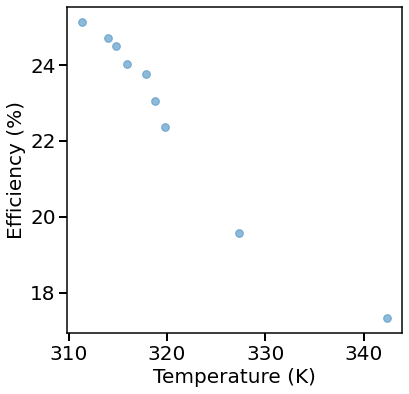

In [11]:
# Extract the set of optimal solutions
Y_real_opts, X_real_opts = exp_comsol.get_optim()

# Parse the optimum into a table
data_opt = io.np_to_dataframe([X_real_opts, Y_real_opts], var_names)
display(data_opt.round(decimals=5))

# Make the pareto front
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(Y_real_opts[:, 0], Y_real_opts[:, 1], s=60, alpha = 0.5)
ax.set_xlabel(var_names[2]);
ax.set_ylabel(var_names[3]);

[Thumbnail](_images/09.png) of this notebook